# Contents
* [Introduction](#Introduction)
* [Imports and configuration](#Imports-and-configuration)
* [Data loading](#Data-loading)
* [Setup](#Setup)
* [Evaluate](#Evaluate)
* [Results](#Results)
* [Discussion](#Discussion)

# Introduction

Feature engineering could continue ad infinitum. Any classifier that implements .predict_proba can generate per-class features that could be useful (calibration can enable predict_proba for models that don't natively implement). These probabilities are all new features. And then two LDA components can be extracted from each of these trios. What's more, you could select any intermediate stage of feature extraction and generate more predicted probabilities or components. And don't forget we have the original FRILL features to tinker with too!

This approach will be limited by how good the FRILL embeddings are without returning to the raw signal. As such, it is worth it to produce such features using the most performant models, as we did with SVM.

This notebook examines the feature importances of the new features using tree-based ensemble methods.

# Imports and configuration

In [1]:
from time import time

notebook_begin_time = time()

# set random seeds

from os import environ
from random import seed as random_seed
from numpy.random import seed as np_seed
from tensorflow.random import set_seed


def reset_seeds(seed: int) -> None:
    """Utility function for resetting random seeds"""
    environ["PYTHONHASHSEED"] = str(seed)
    random_seed(seed)
    np_seed(seed)
    set_seed(seed)


reset_seeds(SEED := 2021)

In [2]:
# extensions
%load_ext autotime
%load_ext lab_black
%load_ext nb_black

In [106]:
# core
import numpy as np
import pandas as pd

# utility
from gc import collect as gc_collect

from tqdm.notebook import tqdm

# typing
from typing import Any, Dict, List

# faster sklearn
from sklearnex import patch_sklearn

patch_sklearn()
del patch_sklearn

# metrics
from sklearn.metrics import log_loss

# other sklearn
from sklearn.ensemble import (
    AdaBoostClassifier,
    ExtraTreesClassifier,
    RandomForestClassifier,
)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("notebook")
%matplotlib inline

# full display of rows and columns
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", None)

# display outputs w/o print calls
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
del InteractiveShell

time: 7.99 ms


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [4]:
# Location of cross validation data
FEATURES_FOLDER = "../10.0-mic-prepare_train-test_splits_on_full_data"

# Location where this notebook will output
DATA_OUT_FOLDER = "."

_ = gc_collect()

time: 115 ms


# Setup

In this section, we define some structures to keep track of models and scores.

In [5]:
FOLDS = (0, 1, 2, 3, 4)

_ = gc_collect()

time: 128 ms


# Feature importance of training data by fold

In [9]:
extras, rfs, adaboosts, before_scores = [], [], [], []
for fold_num in tqdm(FOLDS):

    read_feather = lambda filename: pd.read_feather(
        f"{FEATURES_FOLDER}/cv_{fold_num}/{filename}.feather"
    )

    X_train = read_feather("X_train_FRILL-based_uniQT")
    y_train = read_feather("y_train_untransformed").iloc[:, 0]

    # fit tree ensembles
    adaboosts.append(
        AdaBoostClassifier(
            base_estimator=DecisionTreeClassifier(
                criterion="entropy",
                splitter="random",
                max_depth=1,
                max_features="sqrt",
                random_state=SEED,
            ),
            random_state=SEED,
        ).fit(X_train, y_train)
    )
    extras.append(
        ExtraTreesClassifier(
            criterion="entropy",
            max_depth=15,
            max_features="sqrt",
            bootstrap=True,
            n_jobs=-1,
            random_state=SEED,
            verbose=1,
            class_weight="balanced_subsample",
        ).fit(X_train, y_train)
    )
    rfs.append(
        RandomForestClassifier(
            criterion="entropy",
            max_depth=15,
            max_features="sqrt",
            bootstrap=True,
            n_jobs=-1,
            random_state=SEED,
            verbose=1,
            class_weight="balanced_subsample",
        ).fit(X_train, y_train)
    )

    model = GaussianNB().fit(X_train, y_train)
    before_scores.append(
        log_loss(
            read_feather("y_test_untransformed").iloc[:, 0],
            model.predict_proba(read_feather("X_test_FRILL-based_uniQT")),
        )
    )

  0%|          | 0/5 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   55.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   54.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.2s
[

time: 5min 39s


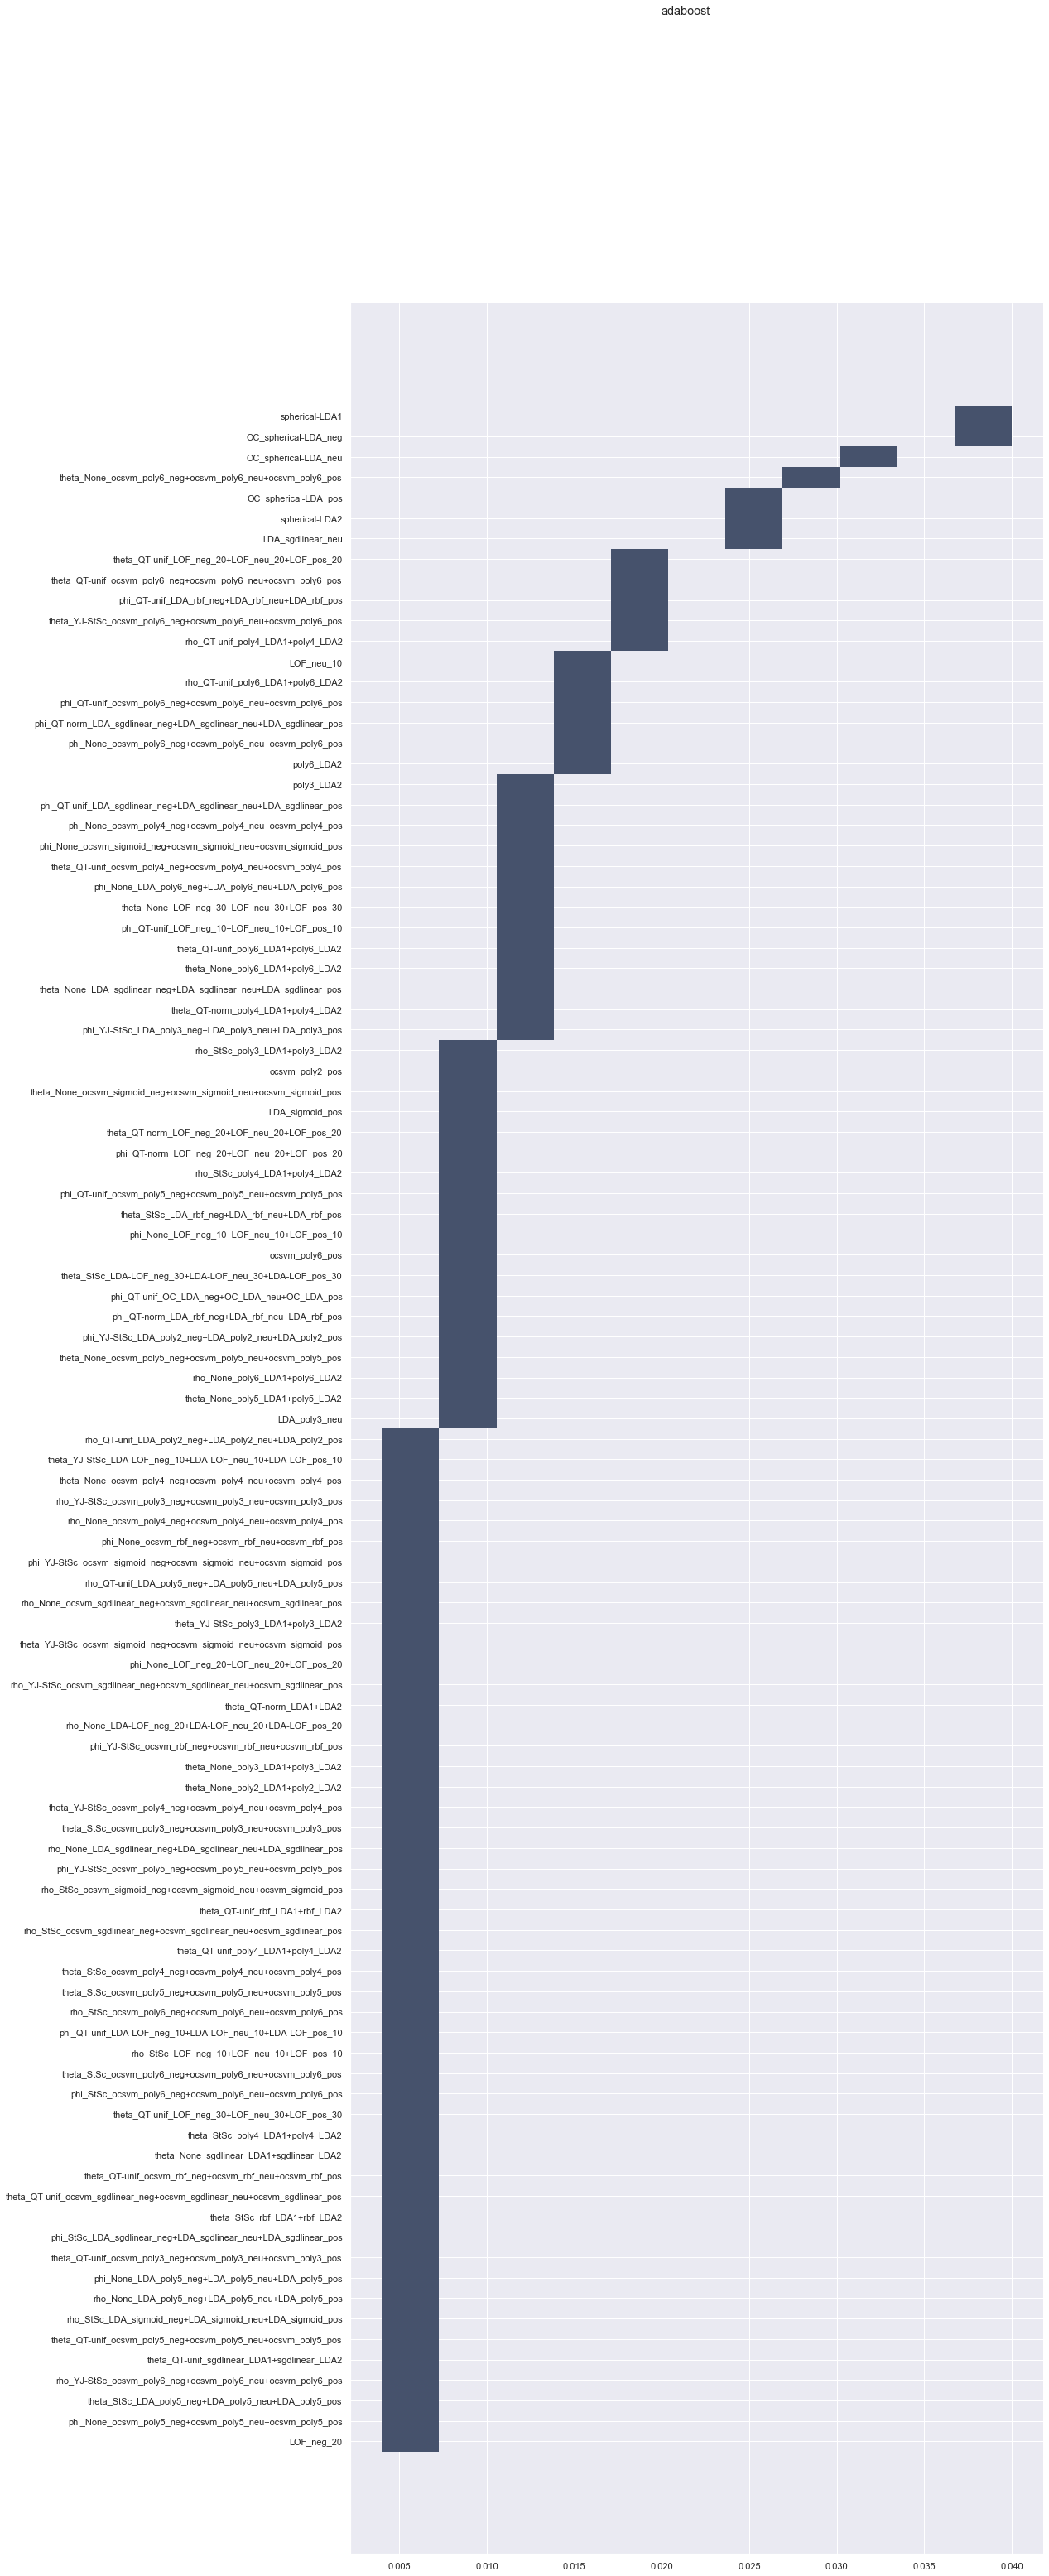

0.009160000000000003


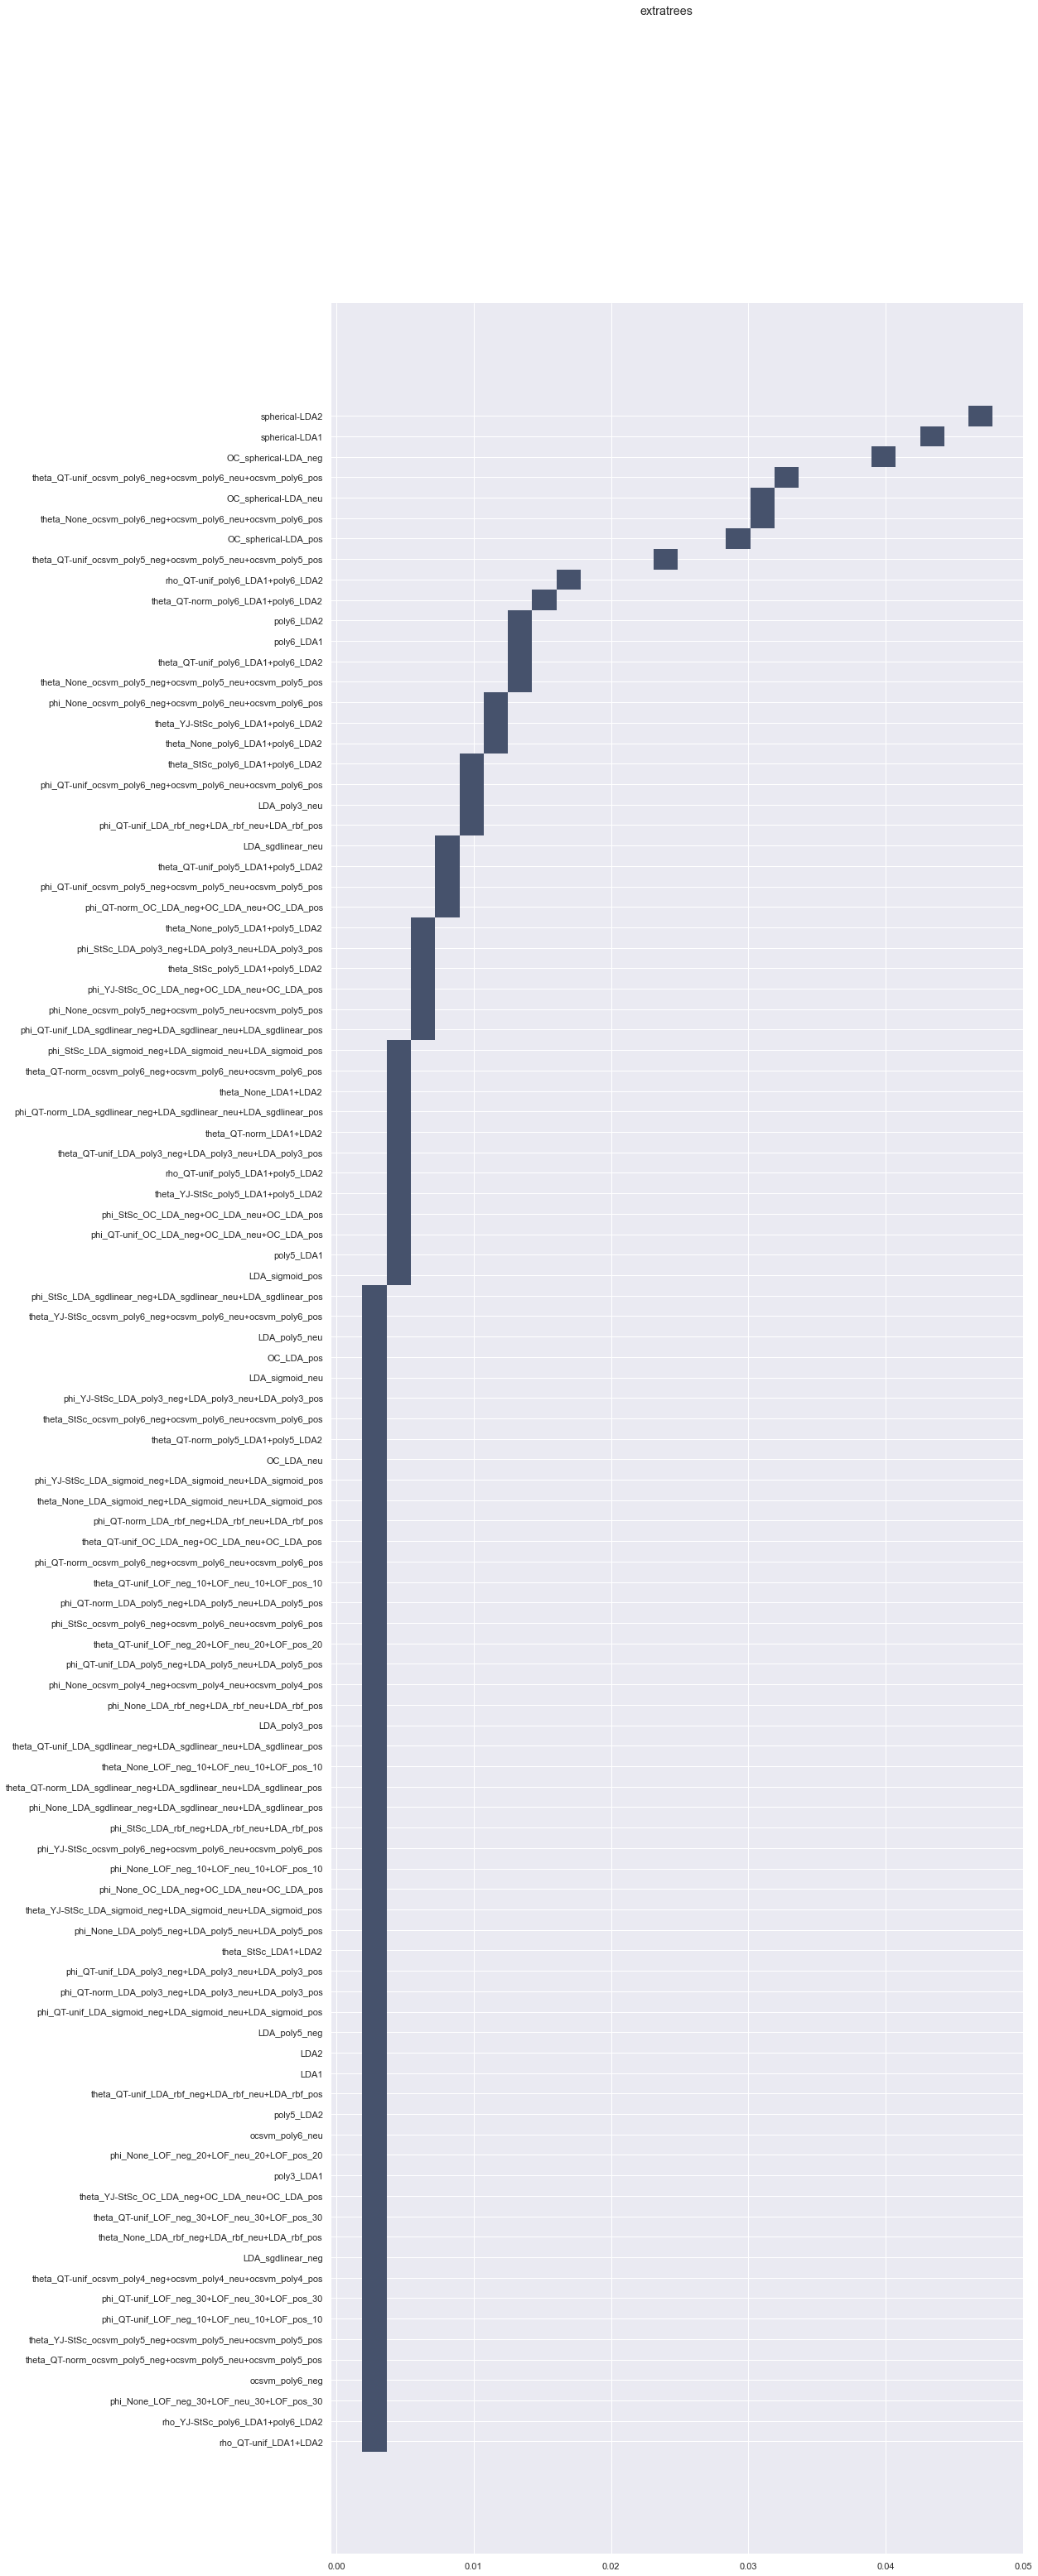

0.007102778826538212


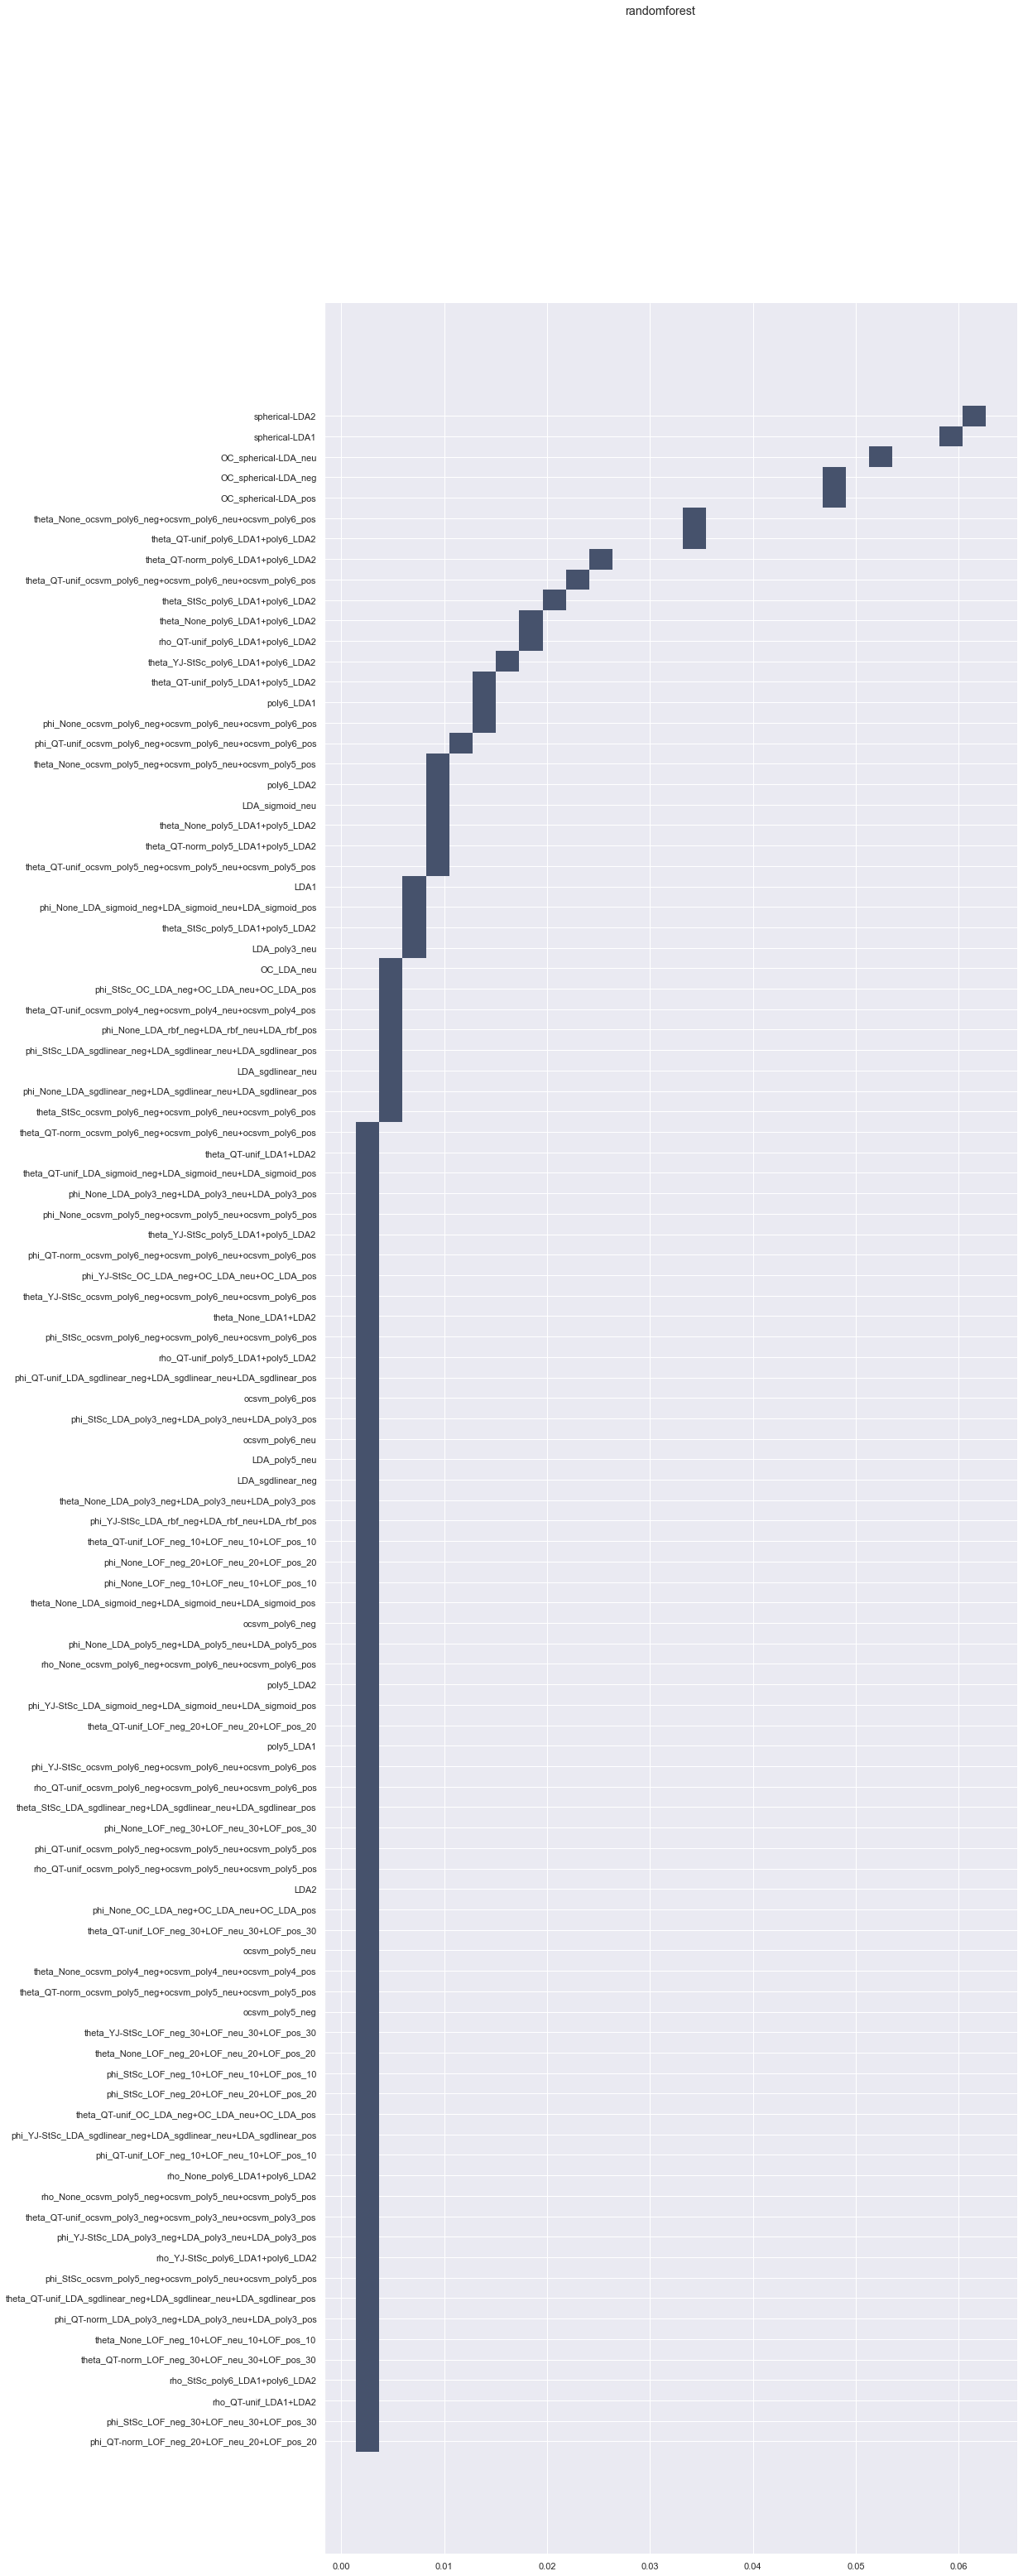

0.007793678308572606
time: 10.5 s


In [36]:
# average feature importances between folds
features_importances_df = lambda ensembles: pd.DataFrame(
    [model.feature_importances_ for model in ensembles], columns=X_train.columns
)
adaboosts_df = features_importances_df(adaboosts)
extras_df = features_importances_df(extras)
rfs_df = features_importances_df(rfs)


def plot_importances_df(df: pd.DataFrame, title: str = "") -> None:
    df = df.mean().sort_values(ascending=False).head(100)
    sns.set(rc={"figure.figsize": (15, 50)})
    sns.histplot(
        data=df,
        x=df.values,
        y=df.index,
        palette="colorblind",
        linewidth=0,
    )
    plt.suptitle(title)
    sns.despine(top=True, right=True)
    # plt.tight_layout()
    plt.show()
    print(np.mean(df.values))


plot_importances_df(adaboosts_df, "adaboost")
plot_importances_df(extras_df, "extratrees")
plot_importances_df(rfs_df, "randomforest")

In [40]:
keep_features = [
    feature
    for feature in X_train.columns
    if any([search in feature for search in ("phi", "theta", "poly6", "spherical")])
]
_ = gc_collect()

time: 200 ms


In [42]:
after_scores = []
for fold_num in tqdm(FOLDS):

    read_feather = lambda filename, columns: pd.read_feather(
        f"{FEATURES_FOLDER}/cv_{fold_num}/{filename}.feather", columns=columns
    )

    X_train = read_feather("X_train_FRILL-based_uniQT", columns=keep_features)
    y_train = read_feather("y_train_untransformed", columns=None).iloc[:, 0]

    model = GaussianNB().fit(X_train, y_train)
    after_scores.append(
        log_loss(
            read_feather("y_test_untransformed", columns=None).iloc[:, 0],
            model.predict_proba(
                read_feather("X_test_FRILL-based_uniQT", columns=keep_features)
            ),
        )
    )

  0%|          | 0/5 [00:00<?, ?it/s]

time: 4.77 s


In [43]:
print(
    f"Log loss changed by {np.mean(np.array(after_scores) - np.array(before_scores)):.4f} after feature selection."
)

Log loss changed by -0.0731 after feature selection.
time: 994 µs


In [44]:
extras_, rfs_, adaboosts_, after_scores2 = [], [], [], []
for fold_num in tqdm(FOLDS):

    read_feather = lambda filename, columns: pd.read_feather(
        f"{FEATURES_FOLDER}/cv_{fold_num}/{filename}.feather", columns=columns
    )

    X_train = read_feather("X_train_FRILL-based_uniQT", columns=keep_features)
    y_train = read_feather("y_train_untransformed", columns=None).iloc[:, 0]

    # fit tree ensembles
    adaboosts_.append(
        AdaBoostClassifier(
            base_estimator=DecisionTreeClassifier(
                criterion="entropy",
                splitter="random",
                max_depth=1,
                max_features="sqrt",
                random_state=SEED,
            ),
            random_state=SEED,
        ).fit(X_train, y_train)
    )
    extras_.append(
        ExtraTreesClassifier(
            criterion="entropy",
            max_depth=15,
            max_features="sqrt",
            bootstrap=True,
            n_jobs=-1,
            random_state=SEED,
            verbose=1,
            class_weight="balanced_subsample",
        ).fit(X_train, y_train)
    )
    rfs_.append(
        RandomForestClassifier(
            criterion="entropy",
            max_depth=15,
            max_features="sqrt",
            bootstrap=True,
            n_jobs=-1,
            random_state=SEED,
            verbose=1,
            class_weight="balanced_subsample",
        ).fit(X_train, y_train)
    )

    model = GaussianNB().fit(X_train, y_train)
    after_scores2.append(
        log_loss(
            read_feather("y_test_untransformed", columns=None).iloc[:, 0],
            model.predict_proba(
                read_feather("X_test_FRILL-based_uniQT", columns=keep_features)
            ),
        )
    )

  0%|          | 0/5 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   41.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   42.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.0s
[

time: 4min 15s


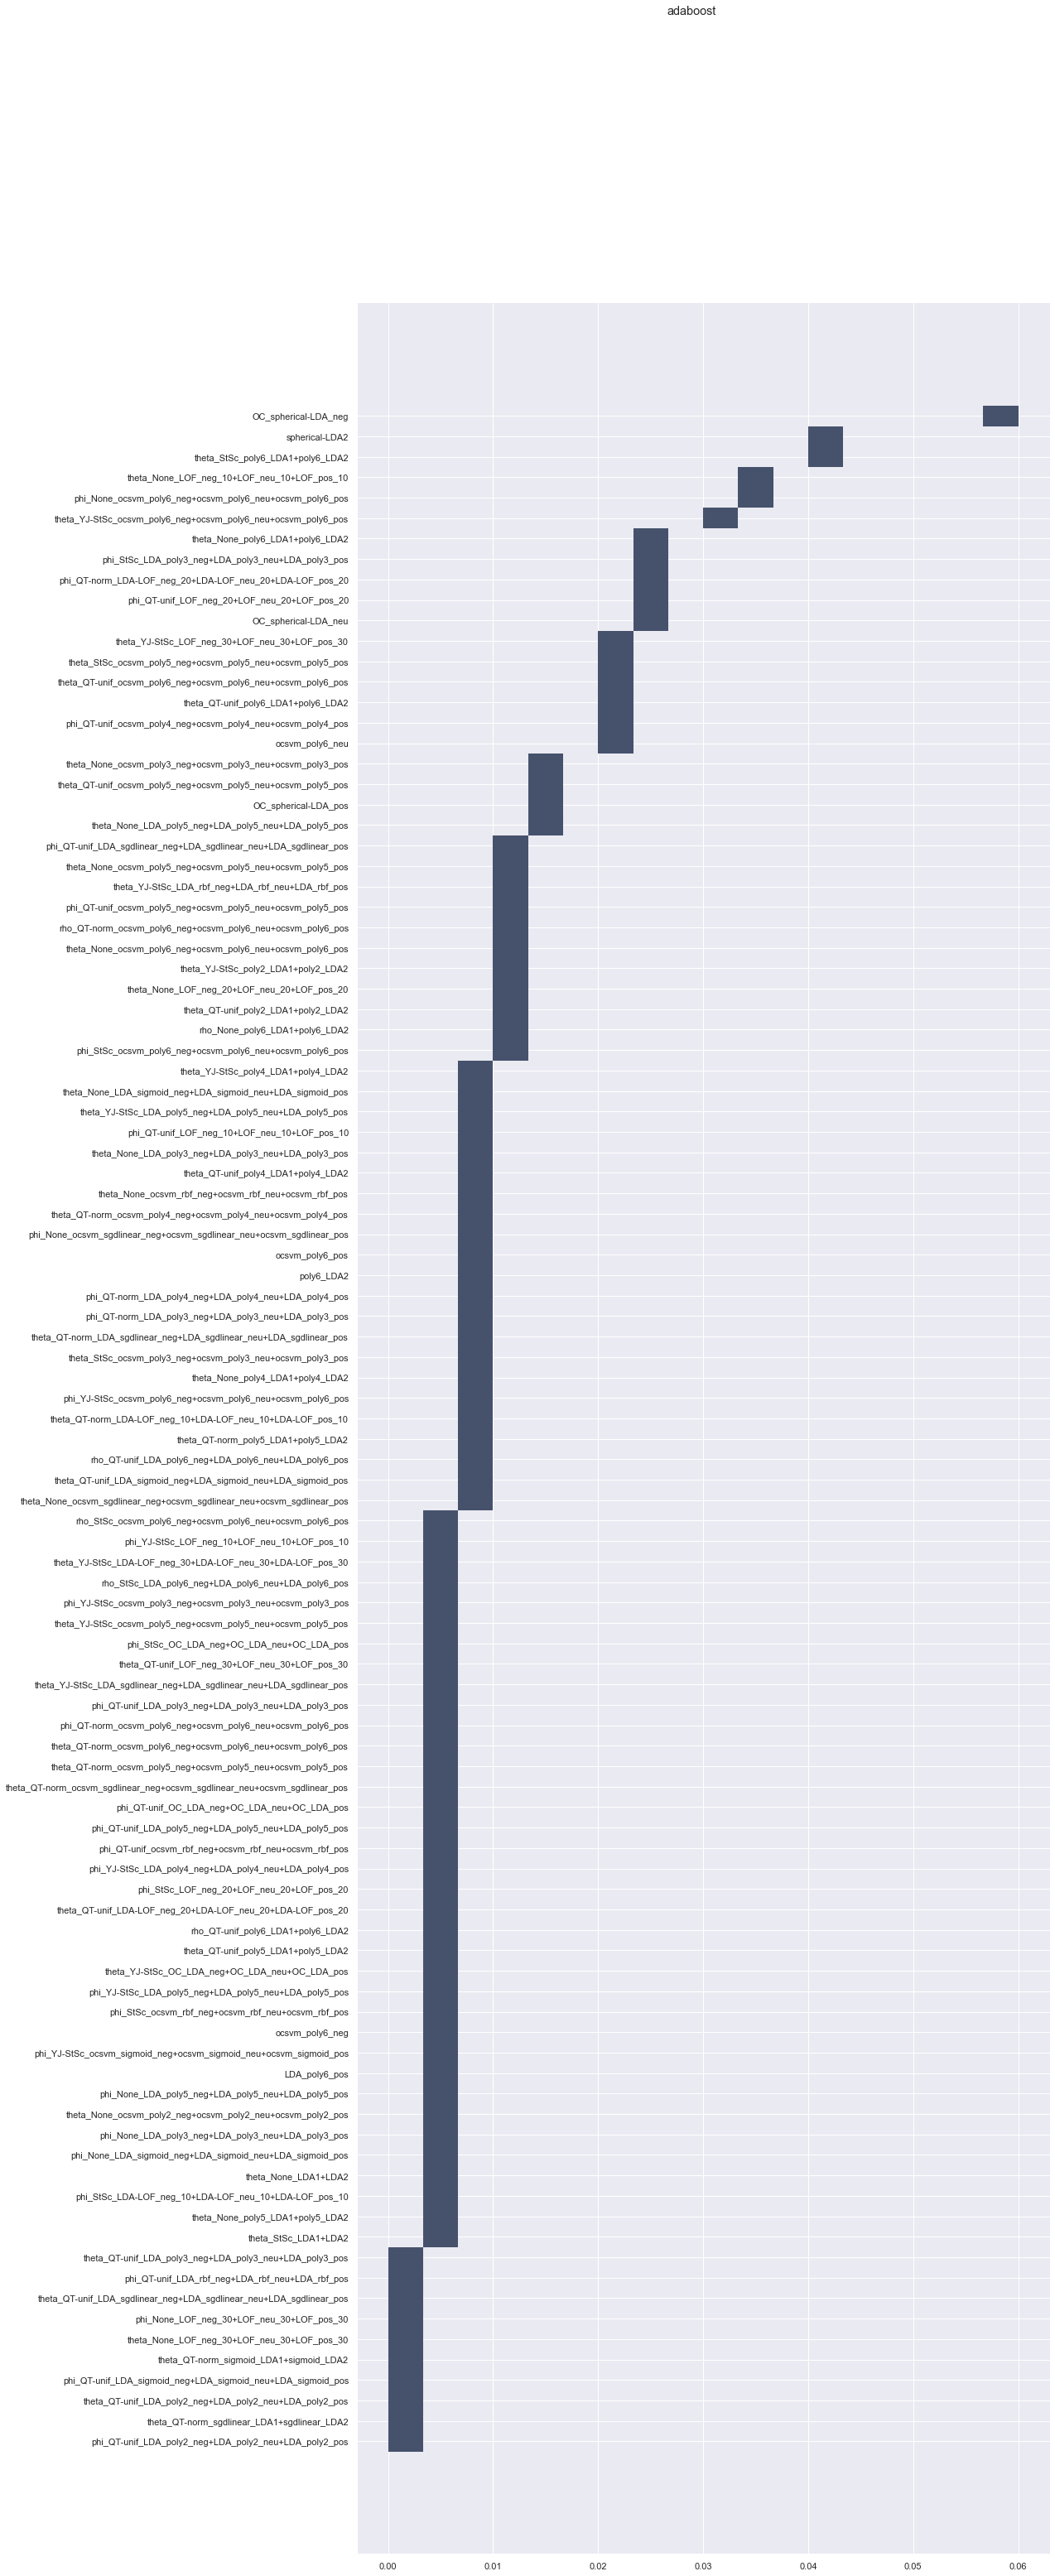

0.01


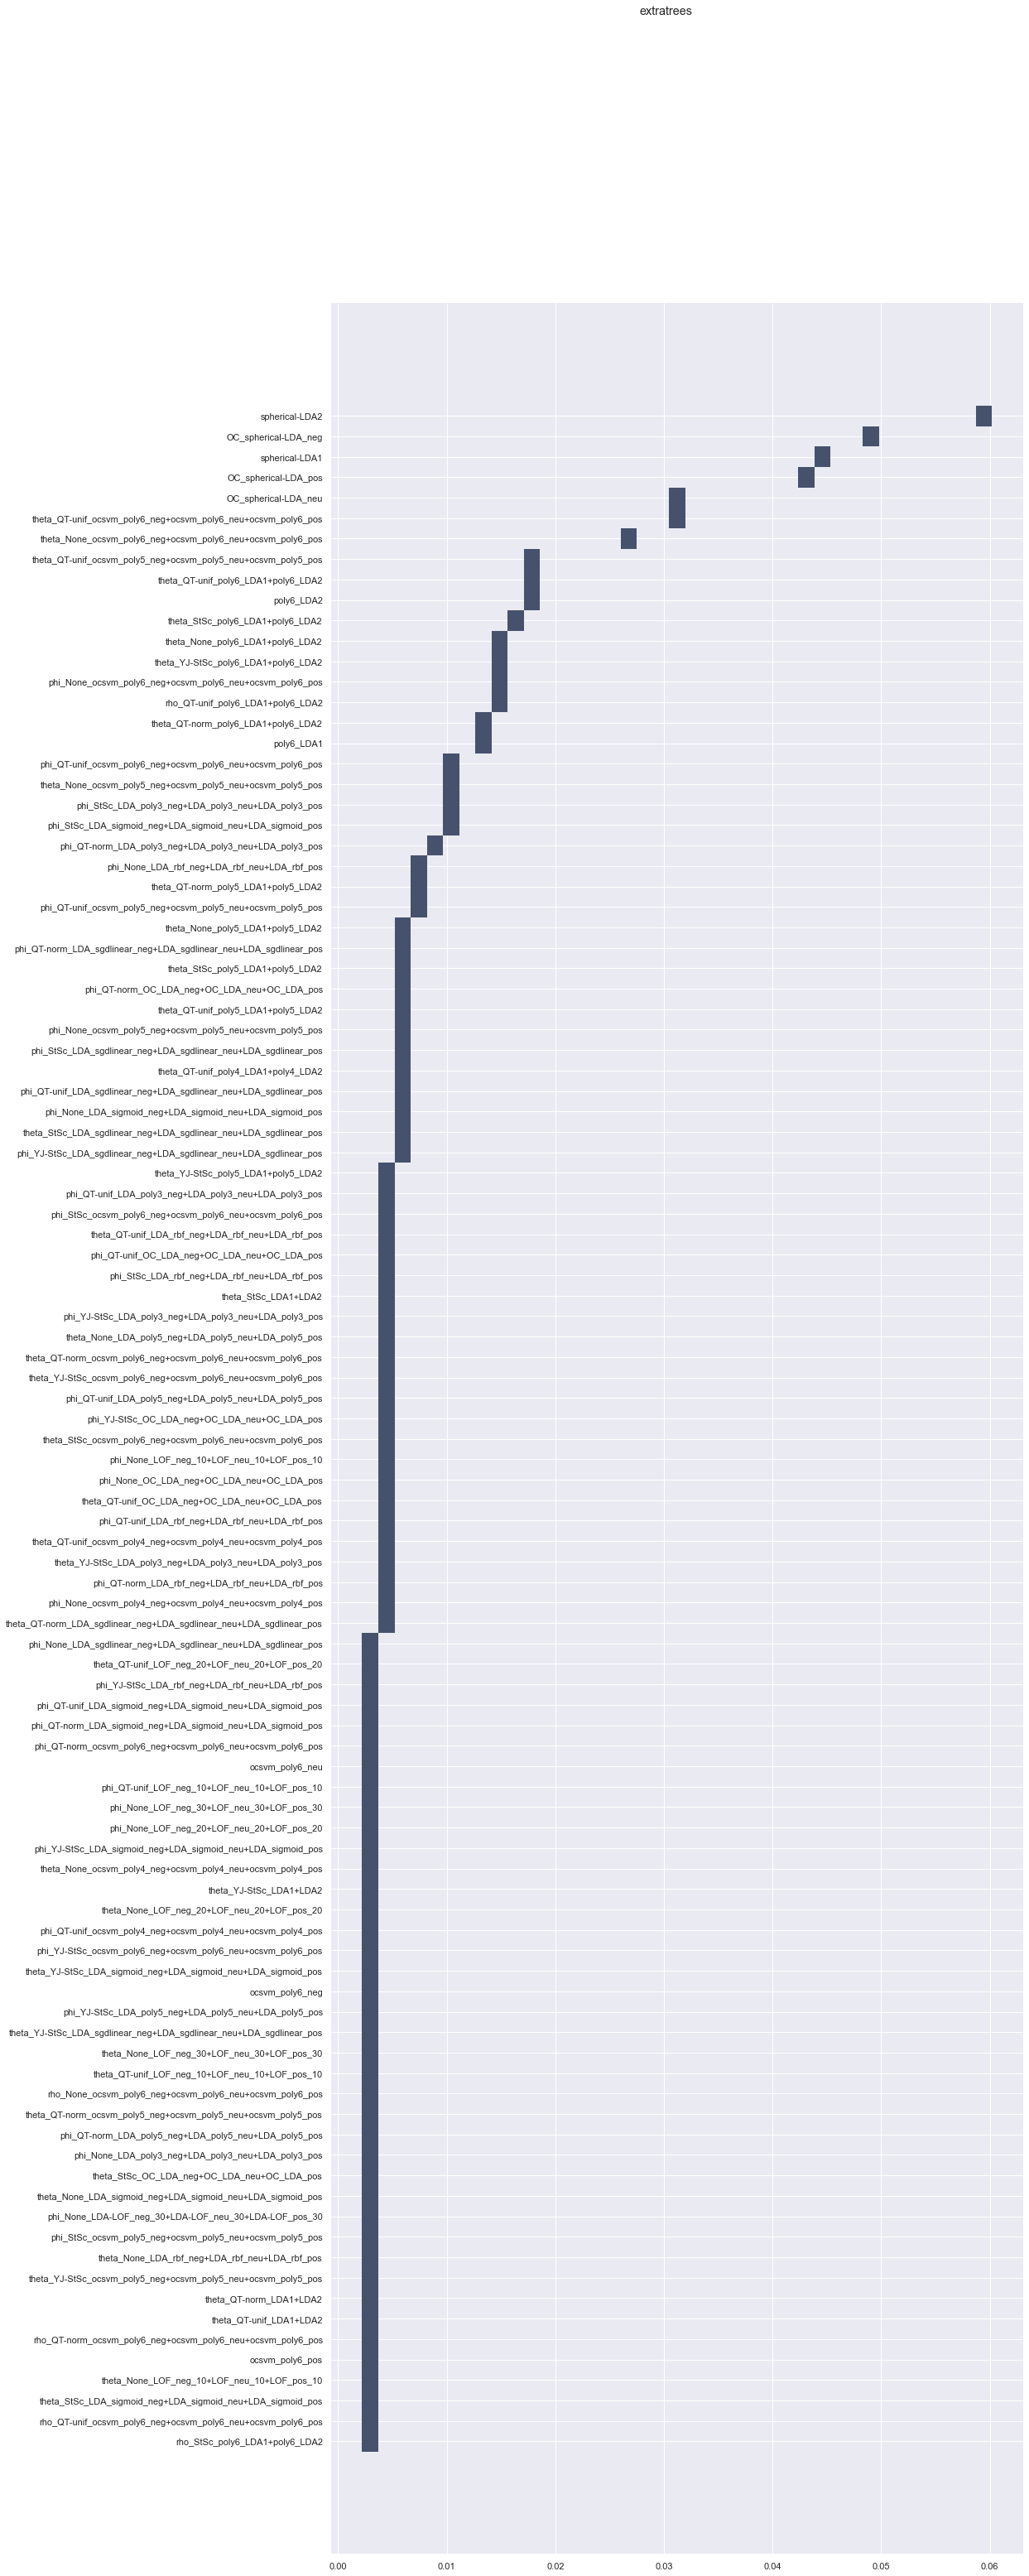

0.007947676885728375


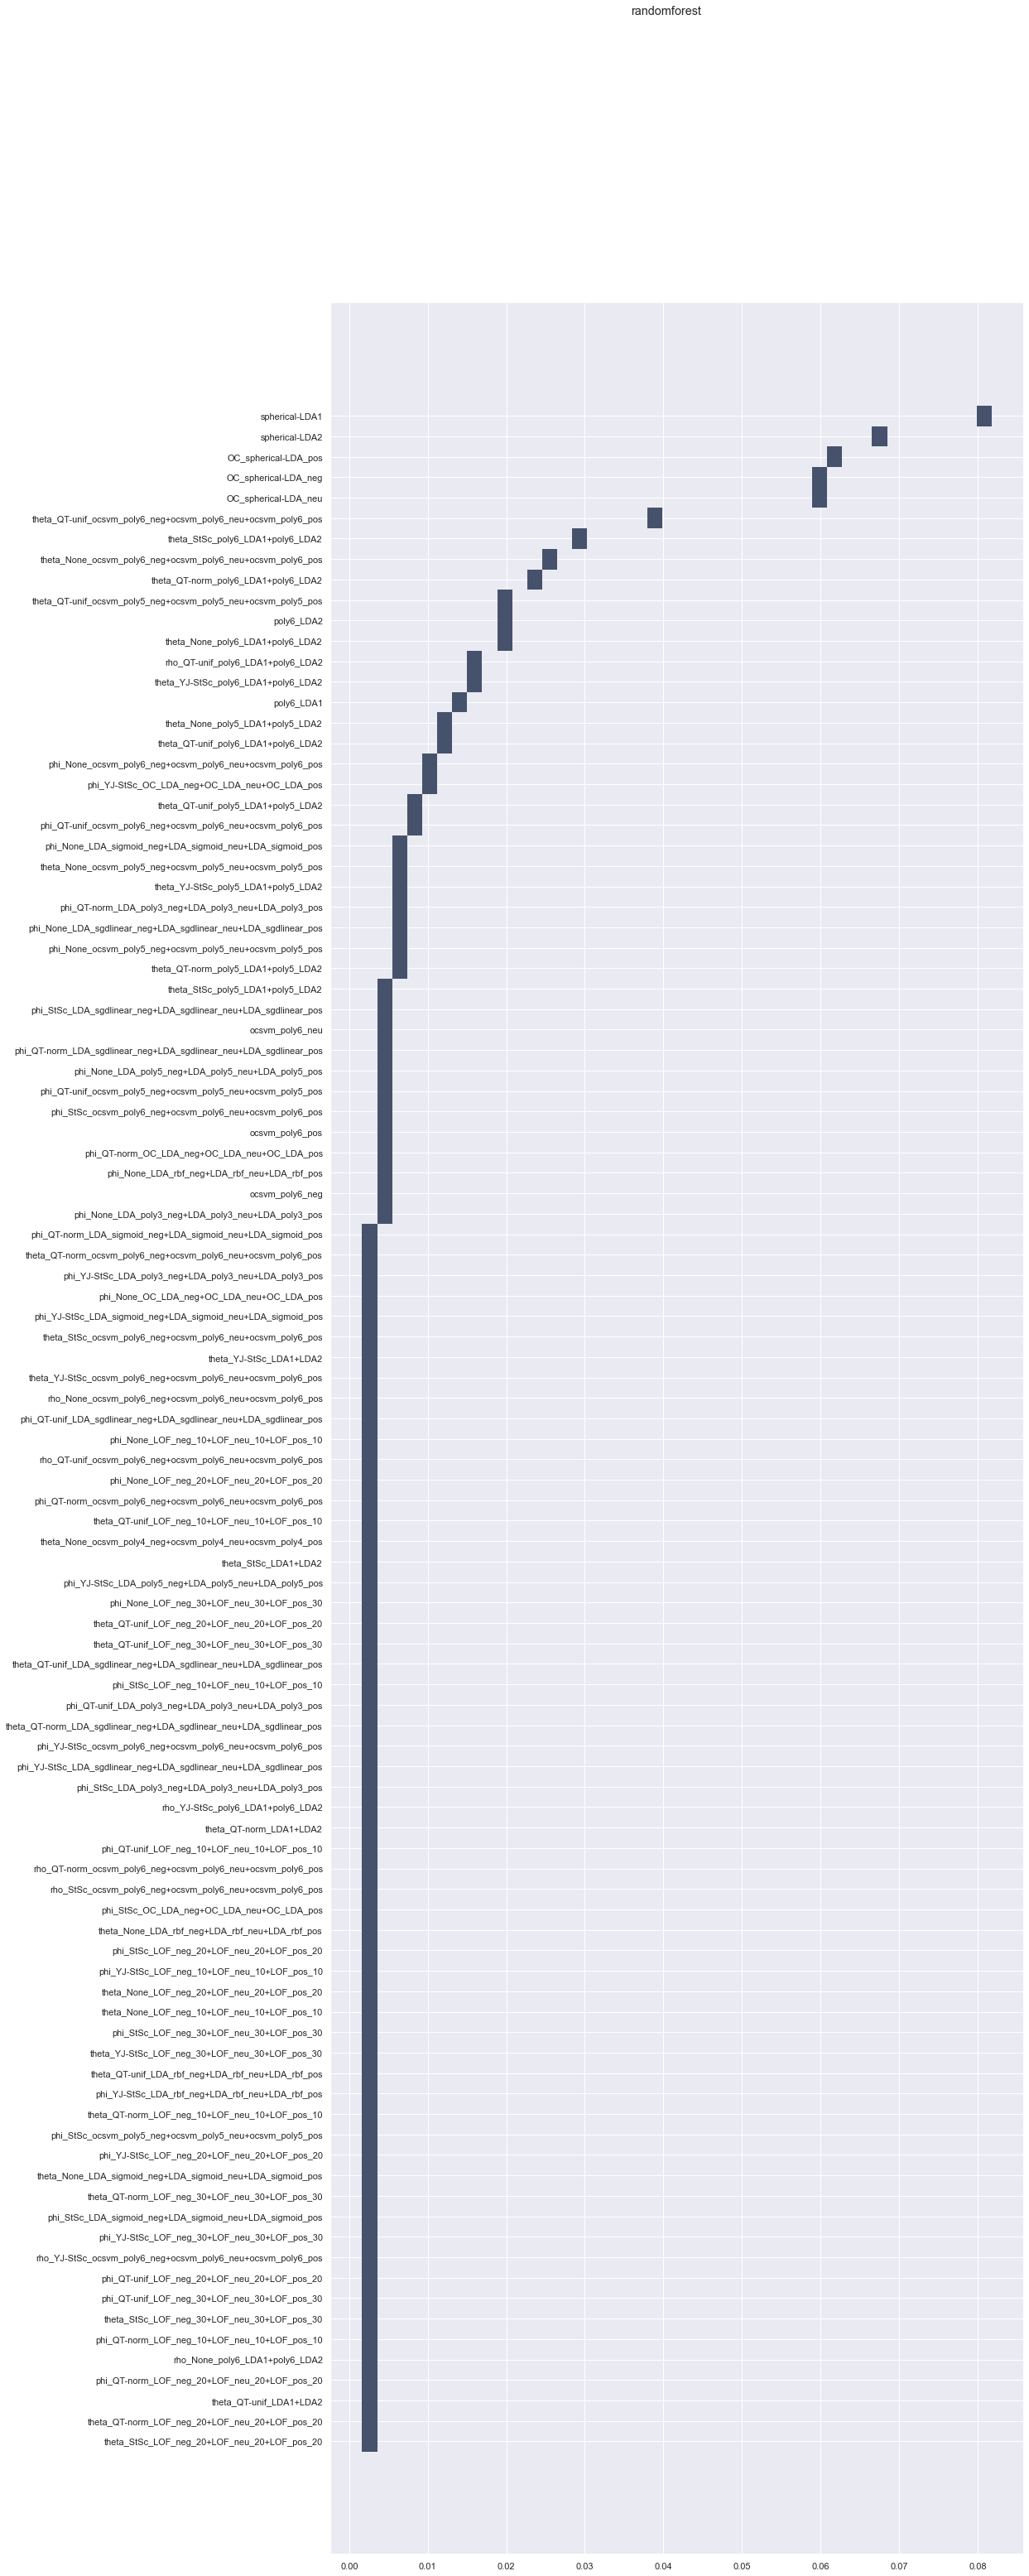

0.00848004024641006
time: 11.5 s


In [45]:
adaboosts_df_ = features_importances_df(adaboosts_)
extras_df_ = features_importances_df(extras_)
rfs_df_ = features_importances_df(rfs_)

plot_importances_df(adaboosts_df_, "adaboost")
plot_importances_df(extras_df_, "extratrees")
plot_importances_df(rfs_df_, "randomforest")

In [47]:
keep_features2 = [
    feature
    for feature in keep_features
    if any(
        [
            search in feature and "rho" not in feature
            for search in ("poly6", "spherical")
        ]
    )
]
_ = gc_collect()

time: 169 ms


In [50]:
after_scores3 = []
for fold_num in tqdm(FOLDS):

    read_feather = lambda filename, columns: pd.read_feather(
        f"{FEATURES_FOLDER}/cv_{fold_num}/{filename}.feather", columns=columns
    )

    X_train = read_feather("X_train_FRILL-based_uniQT", columns=keep_features2)
    y_train = read_feather("y_train_untransformed", columns=None).iloc[:, 0]

    model = GaussianNB().fit(X_train, y_train)
    after_scores3.append(
        log_loss(
            read_feather("y_test_untransformed", columns=None).iloc[:, 0],
            model.predict_proba(
                read_feather("X_test_FRILL-based_uniQT", columns=keep_features2)
            ),
        )
    )

  0%|          | 0/5 [00:00<?, ?it/s]

time: 1.58 s


In [51]:
print(
    f"Log loss changed by {np.mean(np.array(after_scores3) - np.array(after_scores2)):.4f} after feature selection."
)

Log loss changed by -6.4627 after feature selection.
time: 2.01 ms


In [55]:
extras_, rfs_, adaboosts_, after_scores4 = [], [], [], []
for fold_num in tqdm(FOLDS):

    read_feather = lambda filename, columns: pd.read_feather(
        f"{FEATURES_FOLDER}/cv_{fold_num}/{filename}.feather", columns=columns
    )

    X_train = read_feather("X_train_FRILL-based_uniQT", columns=keep_features2)
    y_train = read_feather("y_train_untransformed", columns=None).iloc[:, 0]

    # fit tree ensembles
    adaboosts_.append(
        AdaBoostClassifier(
            base_estimator=DecisionTreeClassifier(
                criterion="entropy",
                splitter="random",
                max_depth=1,
                max_features="sqrt",
                random_state=SEED,
            ),
            random_state=SEED,
        ).fit(X_train, y_train)
    )
    extras_.append(
        ExtraTreesClassifier(
            criterion="entropy",
            max_depth=15,
            max_features="sqrt",
            bootstrap=True,
            n_jobs=-1,
            random_state=SEED,
            verbose=1,
            class_weight="balanced_subsample",
        ).fit(X_train, y_train)
    )
    rfs_.append(
        RandomForestClassifier(
            criterion="entropy",
            max_depth=15,
            max_features="sqrt",
            bootstrap=True,
            n_jobs=-1,
            random_state=SEED,
            verbose=1,
            class_weight="balanced_subsample",
        ).fit(X_train, y_train)
    )

    model = GaussianNB().fit(X_train, y_train)
    after_scores4.append(
        log_loss(
            read_feather("y_test_untransformed", columns=None).iloc[:, 0],
            model.predict_proba(
                read_feather("X_test_FRILL-based_uniQT", columns=keep_features2)
            ),
        )
    )

  0%|          | 0/5 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.9s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   15.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.0s
[

time: 1min 35s


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.5s finished


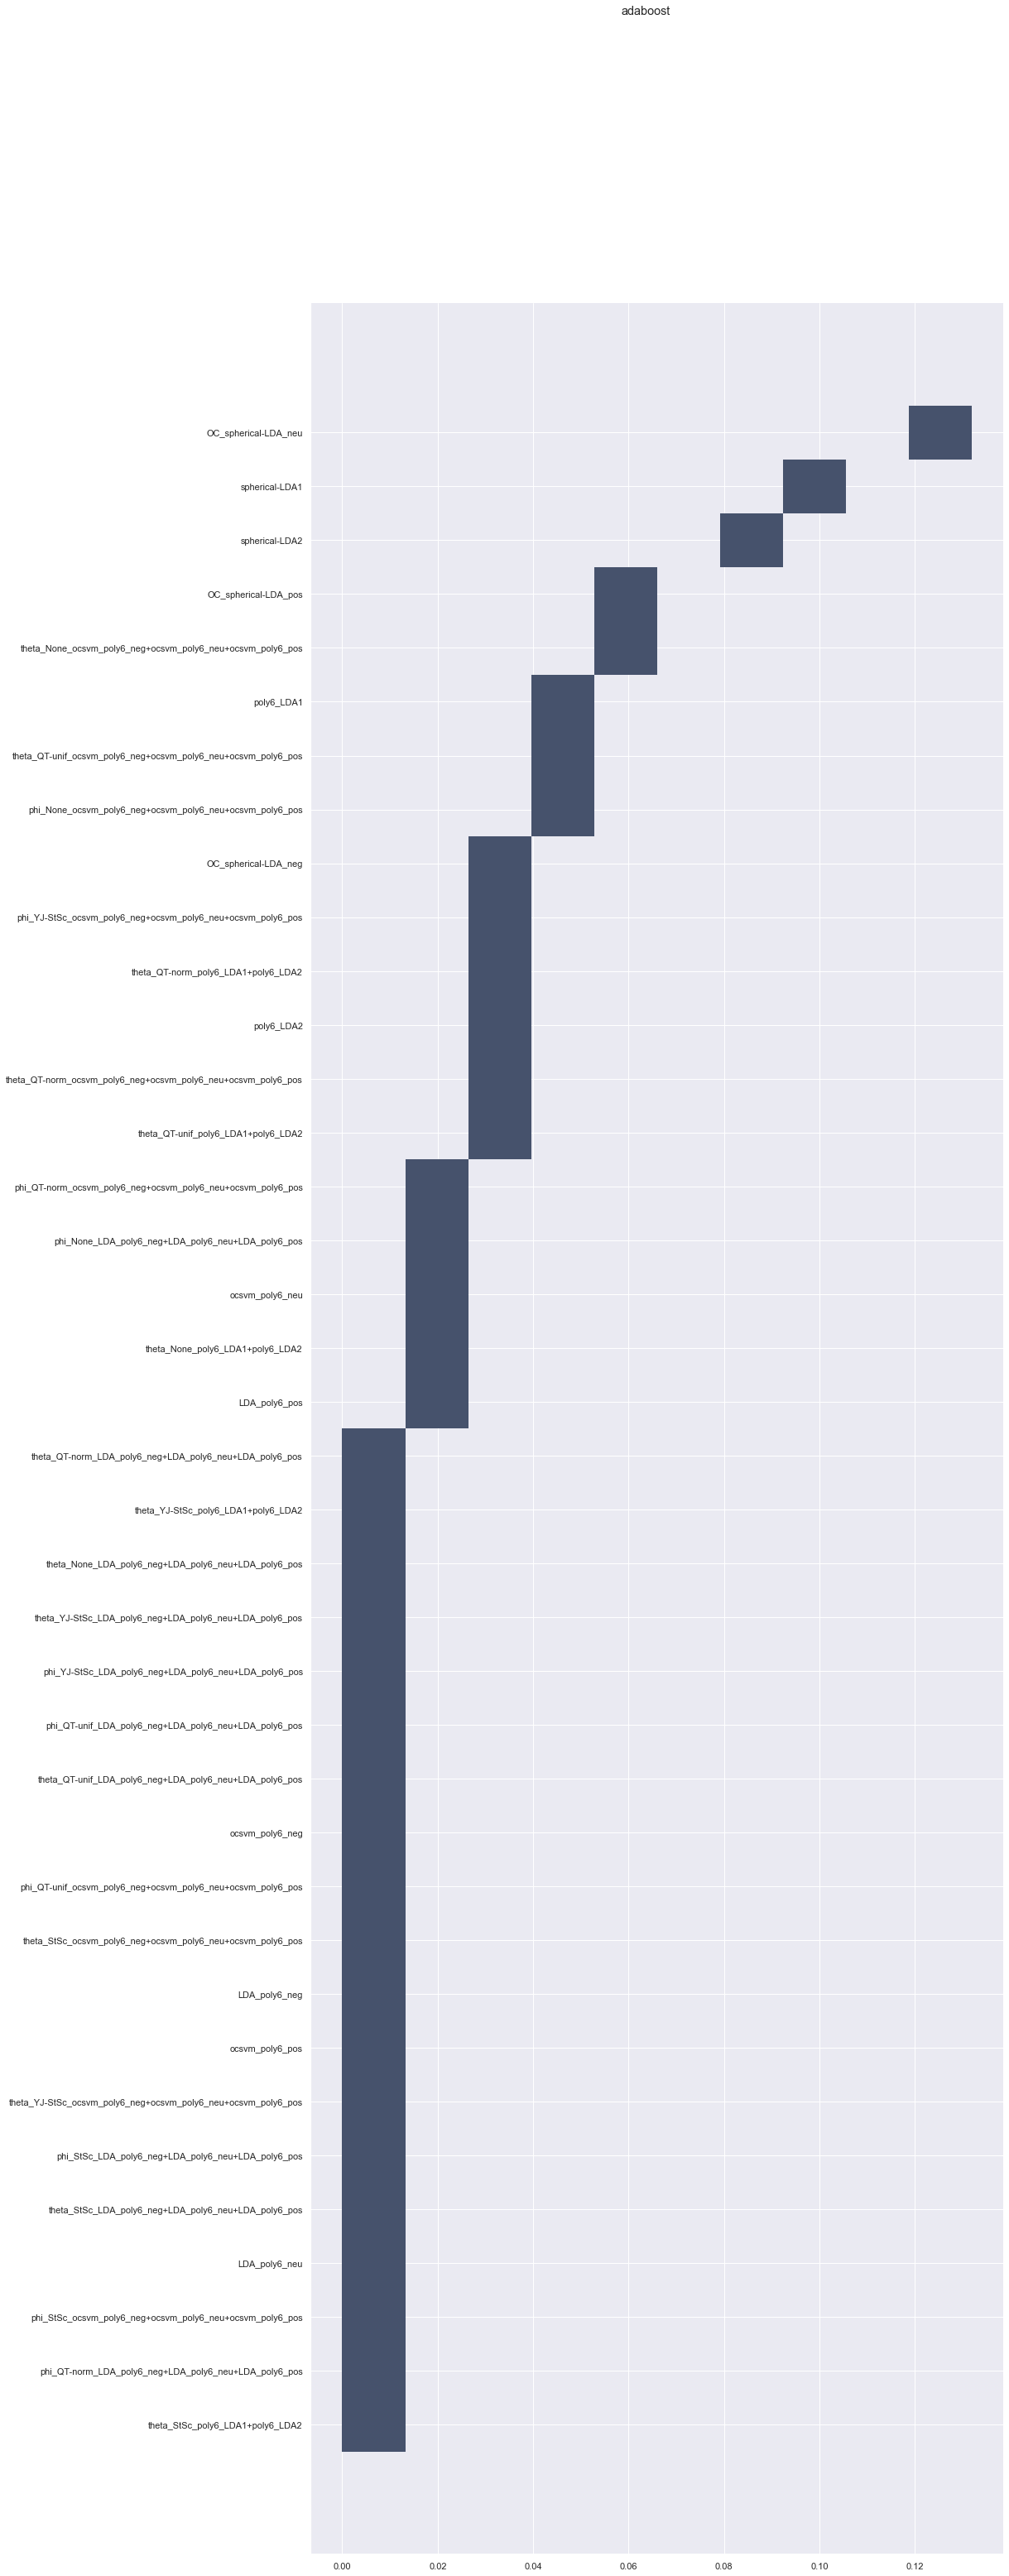

0.02631578947368421


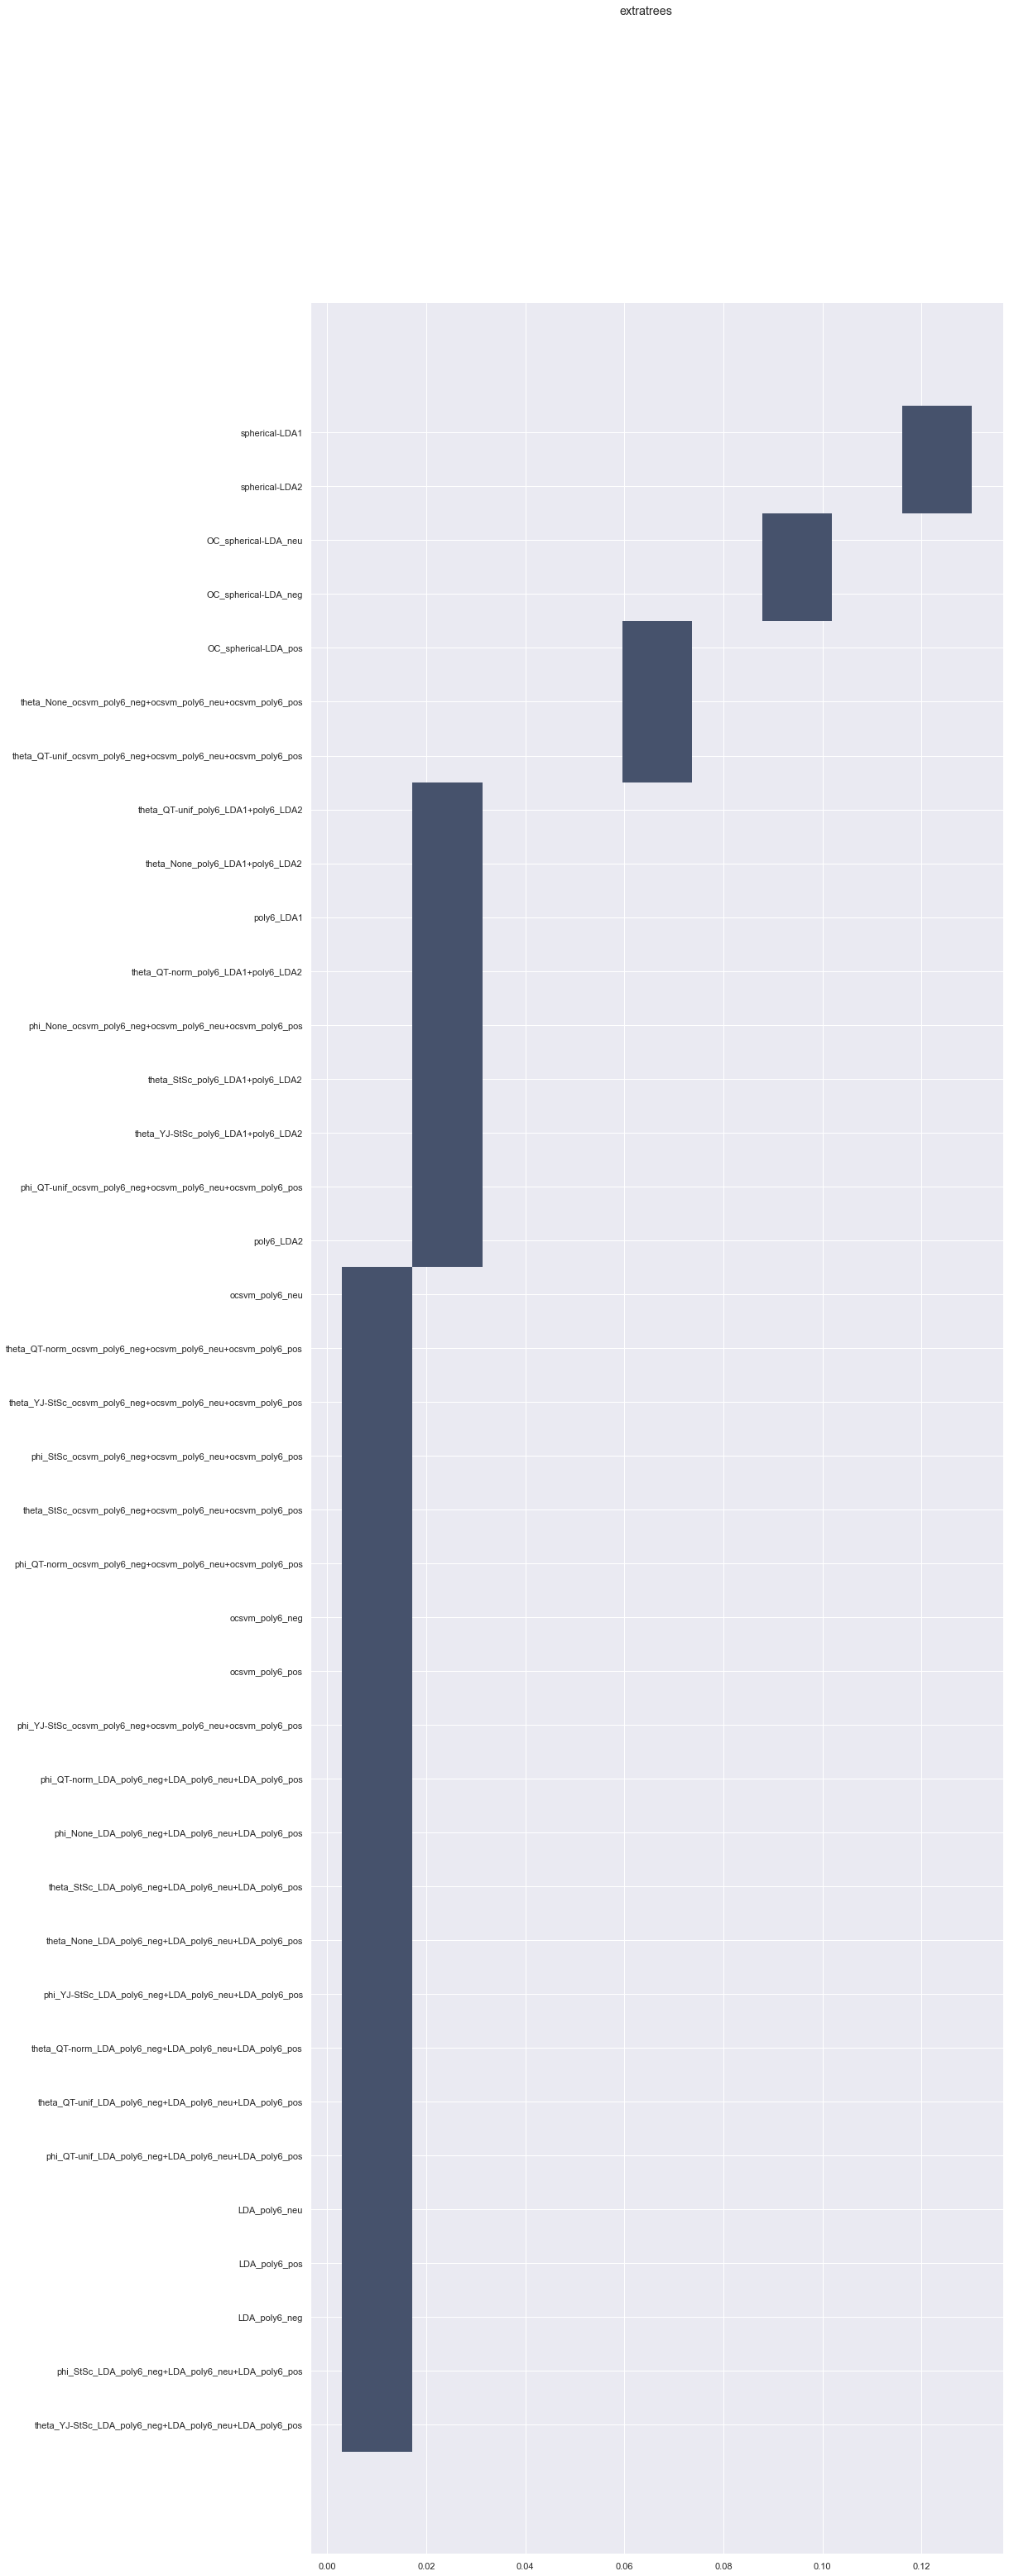

0.02631578947368421


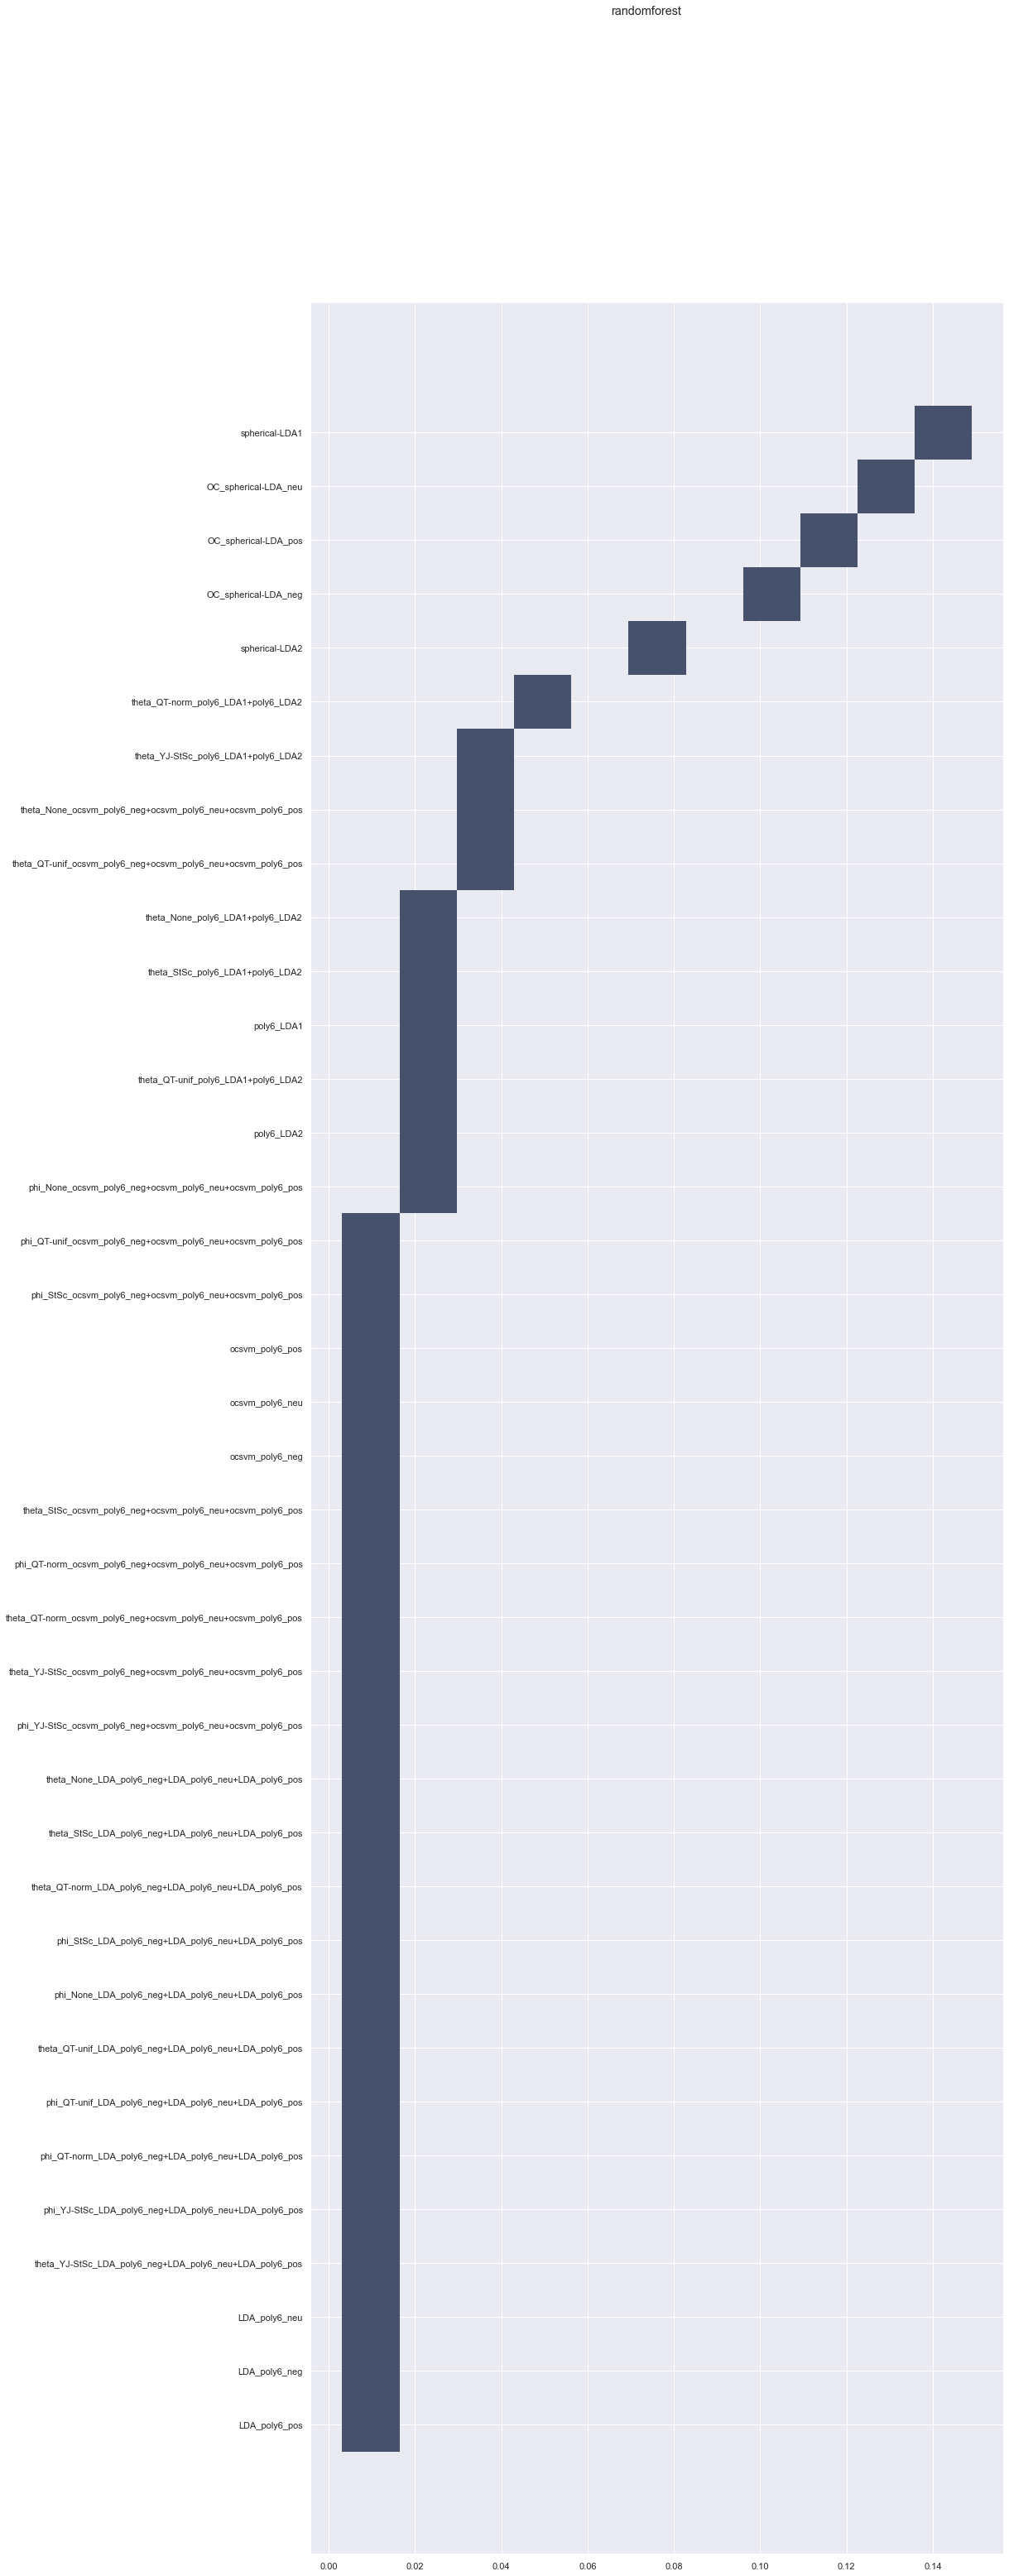

0.02631578947368421
time: 2.39 s


In [56]:
adaboosts_df_ = features_importances_df(adaboosts_)
extras_df_ = features_importances_df(extras_)
rfs_df_ = features_importances_df(rfs_)

plot_importances_df(adaboosts_df_, "adaboost")
plot_importances_df(extras_df_, "extratrees")
plot_importances_df(rfs_df_, "randomforest")

In [57]:
keep_features3 = [feature for feature in keep_features2 if "spherical" in feature]
_ = gc_collect()

time: 161 ms


In [66]:
after_scores4 = []
for fold_num in tqdm(FOLDS):

    read_feather = lambda filename, columns: pd.read_feather(
        f"{FEATURES_FOLDER}/cv_{fold_num}/{filename}.feather", columns=columns
    )

    X_train = read_feather("X_train_FRILL-based_uniQT", columns=keep_features3)
    y_train = read_feather("y_train_untransformed", columns=None).iloc[:, 0]

    model = GaussianNB().fit(X_train, y_train)
    after_scores4.append(
        log_loss(
            read_feather("y_test_untransformed", columns=None).iloc[:, 0],
            model.predict_proba(
                read_feather("X_test_FRILL-based_uniQT", columns=keep_features3)
            ),
        )
    )

  0%|          | 0/5 [00:00<?, ?it/s]

time: 1.22 s


In [59]:
print(
    f"Log loss changed by {np.mean(np.array(after_scores4) - np.array(after_scores3)):.4f} after feature selection."
)

Log loss changed by -3.3065 after feature selection.
time: 999 µs


In [ ]:
keep_features2 = [
    feature
    for feature in keep_features
    if any(
        [
            search in feature and "rho" not in feature
            for search in ("poly6", "spherical")
        ]
    )
]
keep_features = [
    feature
    for feature in X_train.columns
    if any([search in feature for search in ("phi", "theta", "poly6", "spherical")])
]
_ = gc_collect()

_ = gc_collect()

In [63]:
keep_features4 = [
    feature
    for feature in keep_features2
    if "QT" not in feature and "StSc" not in feature
]
keep_features4

['ocsvm_poly6_neg',
 'ocsvm_poly6_neu',
 'ocsvm_poly6_pos',
 'poly6_LDA1',
 'poly6_LDA2',
 'LDA_poly6_neg',
 'LDA_poly6_neu',
 'LDA_poly6_pos',
 'theta_None_poly6_LDA1+poly6_LDA2',
 'theta_None_ocsvm_poly6_neg+ocsvm_poly6_neu+ocsvm_poly6_pos',
 'phi_None_ocsvm_poly6_neg+ocsvm_poly6_neu+ocsvm_poly6_pos',
 'theta_None_LDA_poly6_neg+LDA_poly6_neu+LDA_poly6_pos',
 'phi_None_LDA_poly6_neg+LDA_poly6_neu+LDA_poly6_pos',
 'spherical-LDA1',
 'spherical-LDA2',
 'OC_spherical-LDA_neg',
 'OC_spherical-LDA_neu',
 'OC_spherical-LDA_pos']

time: 6 ms


In [67]:
diff_targeted_with_dropped_prescale = []
for fold_num in tqdm(FOLDS):

    read_feather = lambda filename, columns: pd.read_feather(
        f"{FEATURES_FOLDER}/cv_{fold_num}/{filename}.feather", columns=columns
    )

    X_train = read_feather("X_train_FRILL-based_uniQT", columns=keep_features4)
    y_train = read_feather("y_train_untransformed", columns=None).iloc[:, 0]

    model = GaussianNB().fit(X_train, y_train)
    diff_targeted_with_dropped_prescale.append(
        log_loss(
            read_feather("y_test_untransformed", columns=None).iloc[:, 0],
            model.predict_proba(
                read_feather("X_test_FRILL-based_uniQT", columns=keep_features4)
            ),
        )
    )

  0%|          | 0/5 [00:00<?, ?it/s]

time: 1.33 s


In [69]:
print(
    f"Log loss changed by {np.mean(np.array(diff_targeted_with_dropped_prescale) - np.array(after_scores3)):.4f} after dropping the prescaled sphericals."
)
_ = gc_collect()

Log loss changed by -1.9150 after dropping the prescaled sphericals.
time: 130 ms


In [70]:
print(
    f"Log loss changed by {np.mean(np.array(after_scores4) - np.array(diff_targeted_with_dropped_prescale)):.4f} with targeted only now."
)
_ = gc_collect()

Log loss changed by -1.3916 with targeted only now.
time: 111 ms


In [72]:
keep_features5 = keep_features3 + ["targeted_LDA1", "targeted_LDA2"]
keep_features5

['spherical-LDA1',
 'spherical-LDA2',
 'OC_spherical-LDA_neg',
 'OC_spherical-LDA_neu',
 'OC_spherical-LDA_pos',
 'targeted_LDA1',
 'targeted_LDA2']

time: 4 ms


In [73]:
keep_features4

['ocsvm_poly6_neg',
 'ocsvm_poly6_neu',
 'ocsvm_poly6_pos',
 'poly6_LDA1',
 'poly6_LDA2',
 'LDA_poly6_neg',
 'LDA_poly6_neu',
 'LDA_poly6_pos',
 'theta_None_poly6_LDA1+poly6_LDA2',
 'theta_None_ocsvm_poly6_neg+ocsvm_poly6_neu+ocsvm_poly6_pos',
 'phi_None_ocsvm_poly6_neg+ocsvm_poly6_neu+ocsvm_poly6_pos',
 'theta_None_LDA_poly6_neg+LDA_poly6_neu+LDA_poly6_pos',
 'phi_None_LDA_poly6_neg+LDA_poly6_neu+LDA_poly6_pos',
 'spherical-LDA1',
 'spherical-LDA2',
 'OC_spherical-LDA_neg',
 'OC_spherical-LDA_neu',
 'OC_spherical-LDA_pos']

time: 4 ms


In [84]:
extras_, rfs_, adaboosts_, new_scores = [], [], [], []
for fold_num in tqdm(FOLDS):

    read_feather = lambda filename, columns: pd.read_feather(
        f"{FEATURES_FOLDER}/cv_{fold_num}/{filename}.feather", columns=columns
    )

    y_train = read_feather("y_train_untransformed", columns=None).iloc[:, 0]

    lda = LinearDiscriminantAnalysis().fit(
        read_feather("X_train_FRILL-based_uniQT", columns=keep_features4), y_train
    )
    X_train = pd.concat(
        [
            pd.DataFrame(
                lda.transform(
                    read_feather("X_train_FRILL-based_uniQT", columns=keep_features4)
                ),
                columns=["targeted_LDA1", "targeted_LDA2"],
            ),
            read_feather("X_train_FRILL-based_uniQT", columns=keep_features3),
        ],
        axis="columns",
    )

    # fit tree ensembles
    adaboosts_.append(
        AdaBoostClassifier(
            base_estimator=DecisionTreeClassifier(
                criterion="entropy",
                splitter="random",
                max_depth=1,
                max_features="sqrt",
                random_state=SEED,
            ),
            random_state=SEED,
        ).fit(X_train, y_train)
    )
    extras_.append(
        ExtraTreesClassifier(
            criterion="entropy",
            max_depth=15,
            max_features="sqrt",
            bootstrap=True,
            n_jobs=-1,
            random_state=SEED,
            verbose=1,
            class_weight="balanced_subsample",
        ).fit(X_train, y_train)
    )
    rfs_.append(
        RandomForestClassifier(
            criterion="entropy",
            max_depth=15,
            max_features="sqrt",
            bootstrap=True,
            n_jobs=-1,
            random_state=SEED,
            verbose=1,
            class_weight="balanced_subsample",
        ).fit(X_train, y_train)
    )

    model = GaussianNB().fit(X_train, y_train)
    X_test = pd.concat(
        [
            pd.DataFrame(
                lda.transform(
                    read_feather("X_test_FRILL-based_uniQT", columns=keep_features4)
                ),
                columns=["targeted_LDA1", "targeted_LDA2"],
            ),
            read_feather("X_test_FRILL-based_uniQT", columns=keep_features3),
        ],
        axis="columns",
    )
    new_scores.append(
        log_loss(
            read_feather("y_test_untransformed", columns=None).iloc[:, 0],
            model.predict_proba(X_test),
        )
    )

  0%|          | 0/5 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.7s
[

time: 56 s


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.7s finished


In [86]:
print(
    f"Log loss changed by {np.mean(np.array(new_scores) - np.array(after_scores4)):.4f} with new features."
)
_ = gc_collect()

Log loss changed by 1.5190 with new features.
time: 115 ms


# Discussion

Although best performance may not be achieved through naively including all crafted features, structural multicollinearity doesn't seem to be too much of a problem.

The LDA components based off the most information are the highest ranked. Polynomial kernel with degree 6 appears to be the most important one-class SVM extractor. The theta and phi terms (angles) are more important than the magnitude (rho) terms it seems. The sphericals are often ranked higher than their pre-spherical analogues.

We could extract a couple more big LDAs. We could go back upstream and drop the polynomial kernel features with degree != 6. We could throw out the rho terms from the spherical features since they seem to matter less.

This is probably the simplest solution for feature extraction on the full data for prototyping: 1) remove intermediate scaling step before spherical transforms 2) retain only the LDA components of the spherical coordinates, both the LDA1&2 and the 3 per-class LDAs.

edit: found possibly better features based on poly6 angle features? less loss, but less accuracy and auroc

edit: 
next steps: 0) extract other FRILL-based features as before; 1) retain only one even polynomial kernel (degree 6) and one odd (degree 5) for feature extraction (keep other kernels); 2) remove intermediate scaling step before spherical transforms; 3) do not retain the rho coordinates when performing spherical transform; 4) uniform quantile transform as before; 5) extract big sphericals (2 multiclass, 3 per-class) LDA components as before (only angles since rho was dropped); 6) re-examine importances to confirm; 7) select features; 8) train prototype, tuning var_smoothing, with bagging(gnb)

In [107]:
keep_features0 = [
    feature
    for feature in keep_features
    if "QT" not in feature and "StSc" not in feature
]

spherical_angles = [
    feature for feature in keep_features0 if "theta" in feature or "phi" in feature
]
poly6_features = [feature for feature in keep_features0 if "poly6" in feature]
big_sphericals = [feature for feature in keep_features0 if "spherical" in feature]
big_sphericals
spherical_angles
poly6_features
_ = gc_collect()

['spherical-LDA1',
 'spherical-LDA2',
 'OC_spherical-LDA_neg',
 'OC_spherical-LDA_neu',
 'OC_spherical-LDA_pos']

['theta_None_LDA1+LDA2',
 'theta_None_rbf_LDA1+rbf_LDA2',
 'theta_None_sgdlinear_LDA1+sgdlinear_LDA2',
 'theta_None_sigmoid_LDA1+sigmoid_LDA2',
 'theta_None_poly2_LDA1+poly2_LDA2',
 'theta_None_poly3_LDA1+poly3_LDA2',
 'theta_None_poly4_LDA1+poly4_LDA2',
 'theta_None_poly5_LDA1+poly5_LDA2',
 'theta_None_poly6_LDA1+poly6_LDA2',
 'theta_None_LDA-LOF_neg_10+LDA-LOF_neu_10+LDA-LOF_pos_10',
 'phi_None_LDA-LOF_neg_10+LDA-LOF_neu_10+LDA-LOF_pos_10',
 'theta_None_LDA-LOF_neg_20+LDA-LOF_neu_20+LDA-LOF_pos_20',
 'phi_None_LDA-LOF_neg_20+LDA-LOF_neu_20+LDA-LOF_pos_20',
 'theta_None_LDA-LOF_neg_30+LDA-LOF_neu_30+LDA-LOF_pos_30',
 'phi_None_LDA-LOF_neg_30+LDA-LOF_neu_30+LDA-LOF_pos_30',
 'theta_None_LOF_neg_10+LOF_neu_10+LOF_pos_10',
 'phi_None_LOF_neg_10+LOF_neu_10+LOF_pos_10',
 'theta_None_LOF_neg_20+LOF_neu_20+LOF_pos_20',
 'phi_None_LOF_neg_20+LOF_neu_20+LOF_pos_20',
 'theta_None_LOF_neg_30+LOF_neu_30+LOF_pos_30',
 'phi_None_LOF_neg_30+LOF_neu_30+LOF_pos_30',
 'theta_None_ocsvm_rbf_neg+ocsvm_rb

['ocsvm_poly6_neg',
 'ocsvm_poly6_neu',
 'ocsvm_poly6_pos',
 'poly6_LDA1',
 'poly6_LDA2',
 'LDA_poly6_neg',
 'LDA_poly6_neu',
 'LDA_poly6_pos',
 'rho_None_poly6_LDA1+poly6_LDA2',
 'theta_None_poly6_LDA1+poly6_LDA2',
 'rho_None_ocsvm_poly6_neg+ocsvm_poly6_neu+ocsvm_poly6_pos',
 'theta_None_ocsvm_poly6_neg+ocsvm_poly6_neu+ocsvm_poly6_pos',
 'phi_None_ocsvm_poly6_neg+ocsvm_poly6_neu+ocsvm_poly6_pos',
 'rho_None_LDA_poly6_neg+LDA_poly6_neu+LDA_poly6_pos',
 'theta_None_LDA_poly6_neg+LDA_poly6_neu+LDA_poly6_pos',
 'phi_None_LDA_poly6_neg+LDA_poly6_neu+LDA_poly6_pos']

time: 175 ms


In [122]:
top5_scores = []
top5_plus_anglesLDA_scores = []
acc, auroc = [], []
top5acc, top5auroc, all3acc, all3auroc = [], [], [], []
justanglesacc, justanglesauroc = [], []
justpoly6acc, justpoly6auroc = [], []
anglespoly6acc, anglespoly6auroc = [], []
top5_plus_justpoly6angles_acc, top5_plus_justpoly6angles_auroc = [], []
results = {
    "top5": [],
    "top5_plus_anglesLDA": [],
    "top5_plus_poly6LDA": [],
    "angles_plus_poly6": [],
    "all3": [],
    "just_angles": [],
    "just_poly6": [],
    "justpoly6angles": [],
    "top5_plus_justpoly6angles": [],
}
for fold_num in tqdm(FOLDS):

    read_feather = lambda filename, columns: pd.read_feather(
        f"{FEATURES_FOLDER}/cv_{fold_num}/{filename}.feather", columns=columns
    )

    X_train = read_feather(
        "X_train_FRILL-based_uniQT",
        columns=set(big_sphericals + spherical_angles + poly6_features),
    ).sort_index(axis=1)
    angle_train = X_train[spherical_angles]
    poly6_train = X_train[poly6_features]
    top5_train = X_train[big_sphericals]
    justpoly6angles_train = X_train[
        [
            feature
            for feature in poly6_features
            if "phi" in feature or "theta" in feature
        ]
    ]
    y_train = read_feather("y_train_untransformed", columns=None).iloc[:, 0]

    top5 = GaussianNB().fit(top5_train, y_train)
    angleLDA = LinearDiscriminantAnalysis().fit(angle_train, y_train)
    top5_plus_anglesLDA = GaussianNB().fit(
        pd.concat(
            [
                top5_train,
                angle_components := pd.DataFrame(
                    angleLDA.transform(angle_train),
                    columns=["angleLDA1", "angleLDA2"],
                ),
            ],
            axis="columns",
        ).sort_index(axis=1),
        y_train,
    )
    poly6LDA = LinearDiscriminantAnalysis().fit(poly6_train, y_train)
    top5_plus_poly6LDA = GaussianNB().fit(
        pd.concat(
            [
                top5_train,
                poly6_components := pd.DataFrame(
                    poly6LDA.transform(poly6_train), columns=["poly6LDA1", "poly6LDA2"]
                ),
            ],
            axis="columns",
        ).sort_index(axis=1),
        y_train,
    )
    angles_plus_poly6 = GaussianNB().fit(
        pd.concat([angle_components, poly6_components], axis="columns").sort_index(
            axis=1
        ),
        y_train,
    )
    all3 = GaussianNB().fit(
        pd.concat(
            [top5_train, angle_components, poly6_components], axis="columns"
        ).sort_index(axis=1),
        y_train,
    )
    just_angles = GaussianNB().fit(angle_components, y_train)
    just_poly6 = GaussianNB().fit(poly6_components, y_train)
    justpoly6angles_LDA = LinearDiscriminantAnalysis().fit(
        justpoly6angles_train, y_train
    )
    justpoly6angles = GaussianNB().fit(
        _ := pd.DataFrame(
            justpoly6angles_LDA.transform(justpoly6angles_train),
            columns=["jp6aLDA1", "jp6aLDA2"],
        ),
        y_train,
    )
    top5_plus_justpoly6angles = GaussianNB().fit(
        pd.concat([top5_train, _], axis="columns").sort_index(axis=1), y_train
    )

    X_test = read_feather(
        "X_test_FRILL-based_uniQT",
        columns=set(big_sphericals + spherical_angles + poly6_features),
    ).sort_index(axis=1)
    y_test = read_feather("y_test_untransformed", columns=None).iloc[:, 0]

    save_logloss = lambda results_key, model, data: results[results_key].append(
        log_loss(y_true=y_test, y_pred=model.predict_proba(data))
    )

    save_logloss("top5", top5, X_test[big_sphericals])
    top5acc.append(accuracy_score(y_test, top5.predict(X_test[big_sphericals])))
    top5auroc.append(
        roc_auc_score(
            y_test, top5.predict_proba(X_test[big_sphericals]), multi_class="ovo"
        )
    )
    save_logloss(
        "top5_plus_anglesLDA",
        top5_plus_anglesLDA,
        pd.concat(
            [
                X_test[big_sphericals],
                test_angleLDA := pd.DataFrame(
                    angleLDA.transform(X_test[spherical_angles]),
                    columns=["angleLDA1", "angleLDA2"],
                ),
            ],
            axis="columns",
        ).sort_index(axis=1),
    )
    save_logloss(
        "top5_plus_poly6LDA",
        top5_plus_poly6LDA,
        pd.concat(
            [
                X_test[big_sphericals],
                test_poly6LDA := pd.DataFrame(
                    poly6LDA.transform(X_test[poly6_features]),
                    columns=["poly6LDA1", "poly6LDA2"],
                ),
            ],
            axis="columns",
        ).sort_index(axis=1),
    )
    save_logloss(
        "angles_plus_poly6",
        angles_plus_poly6,
        _ := pd.concat([test_angleLDA, test_poly6LDA], axis="columns").sort_index(
            axis=1
        ),
    )
    anglespoly6acc.append(accuracy_score(y_test, angles_plus_poly6.predict(_)))
    anglespoly6auroc.append(
        roc_auc_score(y_test, angles_plus_poly6.predict_proba(_), multi_class="ovo")
    )
    save_logloss(
        "all3",
        all3,
        all3data := pd.concat(
            [X_test[big_sphericals], test_angleLDA, test_poly6LDA], axis="columns"
        ).sort_index(axis=1),
    )
    all3acc.append(accuracy_score(y_test, all3.predict(all3data)))
    all3auroc.append(
        roc_auc_score(y_test, all3.predict_proba(all3data), multi_class="ovo")
    )
    save_logloss("just_angles", just_angles, test_angleLDA)
    justanglesacc.append(accuracy_score(y_test, just_angles.predict(test_angleLDA)))
    justanglesauroc.append(
        roc_auc_score(
            y_test, just_angles.predict_proba(test_angleLDA), multi_class="ovo"
        )
    )
    save_logloss("just_poly6", just_poly6, test_poly6LDA)
    justpoly6acc.append(accuracy_score(y_test, just_poly6.predict(test_poly6LDA)))
    justpoly6auroc.append(
        roc_auc_score(
            y_test, just_poly6.predict_proba(test_poly6LDA), multi_class="ovo"
        )
    )
    p6_feat = [
        feature for feature in poly6_features if "phi" in feature or "theta" in feature
    ]
    save_logloss(
        "justpoly6angles",
        justpoly6angles,
        p6_featLDAs := pd.DataFrame(
            justpoly6angles_LDA.transform(X_test[p6_feat]),
            columns=["jp6aLDA1", "jp6aLDA2"],
        ),
    )

    acc.append(accuracy_score(y_test, justpoly6angles.predict(p6_featLDAs)))
    auroc.append(
        roc_auc_score(
            y_test, justpoly6angles.predict_proba(p6_featLDAs), multi_class="ovo"
        )
    )
    save_logloss(
        "top5_plus_justpoly6angles",
        top5_plus_justpoly6angles,
        _ := pd.concat(
            [X_test[big_sphericals], p6_featLDAs], axis="columns"
        ).sort_index(axis=1),
    )
    top5_plus_justpoly6angles_acc.append(
        accuracy_score(y_test, top5_plus_justpoly6angles.predict(_))
    )
    top5_plus_justpoly6angles_auroc.append(
        roc_auc_score(
            y_test, top5_plus_justpoly6angles.predict_proba(_), multi_class="ovo"
        )
    )

for key in results:
    print(f"test loss for {key}: {np.mean(results[key]):.4f}")
print("justpoly6angles")
print(_1 := np.mean(acc))
print(_2 := np.mean(auroc))
print(_1 + _2)
print(_1 + _2 - np.mean(results["justpoly6angles"]))
print("top5")
print(_1 := np.mean(top5acc))
print(_2 := np.mean(top5auroc))
print(_1 + _2)
print(_1 + _2 - np.mean(results["top5"]))
print("all3")
print(_1 := np.mean(all3acc))
print(_2 := np.mean(all3auroc))
print(_1 + _2)
print(_1 + _2 - np.mean(results["all3"]))
print("just_poly6")
print(_1 := np.mean(justpoly6acc))
print(_2 := np.mean(justpoly6auroc))
print(_1 + _2)
print(_1 + _2 - np.mean(results["just_poly6"]))
print("just_angles")
print(_1 := np.mean(justanglesacc))
print(_2 := np.mean(justanglesauroc))
print(_1 + _2)
print(_1 + _2 - np.mean(results["just_angles"]))
print("angles_plus_poly6")
print(_1 := np.mean(anglespoly6acc))
print(_2 := np.mean(anglespoly6auroc))
print(_1 + _2)
print(_1 + _2 - np.mean(results["angles_plus_poly6"]))
print("top5_plus_justpoly6angles")
print(_1 := np.mean(top5_plus_justpoly6angles_acc))
print(_2 := np.mean(top5_plus_justpoly6angles_auroc))
print(_1 + _2)
print(_1 + _2 - np.mean(results["top5_plus_justpoly6angles"]))

  0%|          | 0/5 [00:00<?, ?it/s]

test loss for top5: 3.3330
test loss for top5_plus_anglesLDA: 3.9734
test loss for top5_plus_poly6LDA: 3.9169
test loss for angles_plus_poly6: 1.8602
test loss for all3: 4.5857
test loss for just_angles: 1.1998
test loss for just_poly6: 1.1489
test loss for justpoly6angles: 1.0448
test loss for top5_plus_justpoly6angles: 3.7310
justpoly6angles
0.5763275392228457
0.7385008084221669
1.3148283476450127
0.270066447689
top5
0.6159455428654441
0.7548493131452261
1.3707948560106702
-1.962232203135663
all3
0.6121282022231693
0.7620080872936771
1.3741362895168465
-3.211593825733368
just_poly6
0.5995587166609054
0.7426709895812834
1.3422297062421888
0.19329729362968218
just_angles
0.5962574573712546
0.7543782843330551
1.3506357417043096
0.15084995262205148
angles_plus_poly6
0.5993812118760834
0.7573071713048177
1.3566883831809011
-0.5035071122803625
top5_plus_justpoly6angles
0.6116632930279224
0.7598189082411697
1.3714822012690921
-2.3594816149520055
time: 9.71 s


We could just use the angle poly6 features alone?

In [ ]:
[feature for feature in poly6_features if "phi" in feature or "theta" in feature]

['theta_None_poly6_LDA1+poly6_LDA2',
 'theta_None_ocsvm_poly6_neg+ocsvm_poly6_neu+ocsvm_poly6_pos',
 'phi_None_ocsvm_poly6_neg+ocsvm_poly6_neu+ocsvm_poly6_pos',
 'theta_None_LDA_poly6_neg+LDA_poly6_neu+LDA_poly6_pos',
 'phi_None_LDA_poly6_neg+LDA_poly6_neu+LDA_poly6_pos']

time: 4 ms


In [123]:
extras, rfs, adaboosts, before_scores = [], [], [], []
for fold_num in tqdm(FOLDS):

    read_feather = lambda filename: pd.read_feather(
        f"{FEATURES_FOLDER}/cv_{fold_num}/{filename}.feather"
    )

    X_train = read_feather("X_train_FRILL-based_uniQT")
    y_train = read_feather("y_train_untransformed").iloc[:, 0]

    # fit tree ensembles
    adaboosts.append(
        AdaBoostClassifier(
            base_estimator=DecisionTreeClassifier(
                criterion="entropy",
                splitter="random",
                max_depth=1,
                max_features="sqrt",
                random_state=SEED,
            ),
            random_state=SEED,
        ).fit(X_train, y_train)
    )
    extras.append(
        ExtraTreesClassifier(
            criterion="entropy",
            max_depth=15,
            max_features="sqrt",
            bootstrap=True,
            n_jobs=-1,
            random_state=SEED,
            verbose=1,
            class_weight="balanced_subsample",
        ).fit(X_train, y_train)
    )
    rfs.append(
        RandomForestClassifier(
            criterion="entropy",
            max_depth=15,
            max_features="sqrt",
            bootstrap=True,
            n_jobs=-1,
            random_state=SEED,
            verbose=1,
            class_weight="balanced_subsample",
        ).fit(X_train, y_train)
    )

    model = GaussianNB().fit(X_train, y_train)
    before_scores.append(
        log_loss(
            read_feather("y_test_untransformed").iloc[:, 0],
            model.predict_proba(read_feather("X_test_FRILL-based_uniQT")),
        )
    )

  0%|          | 0/5 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   57.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.5s
[

time: 6min 14s


In [124]:
# average feature importances between folds
features_importances_df = lambda ensembles: pd.DataFrame(
    [model.feature_importances_ for model in ensembles], columns=X_train.columns
)
adaboosts_df = features_importances_df(adaboosts)
extras_df = features_importances_df(extras)
rfs_df = features_importances_df(rfs)


list_least_important = lambda df: df.mean().sort_values(ascending=True).head(100)

list_least_important(adaboosts_df)
list_least_important(extras_df)
list_least_important(rfs_df)

LDA1                                                                         0.0
theta_YJ-StSc_LDA_poly3_neg+LDA_poly3_neu+LDA_poly3_pos                      0.0
rho_YJ-StSc_LDA_poly3_neg+LDA_poly3_neu+LDA_poly3_pos                        0.0
theta_YJ-StSc_LDA_poly2_neg+LDA_poly2_neu+LDA_poly2_pos                      0.0
rho_YJ-StSc_LDA_poly2_neg+LDA_poly2_neu+LDA_poly2_pos                        0.0
phi_YJ-StSc_LDA_sigmoid_neg+LDA_sigmoid_neu+LDA_sigmoid_pos                  0.0
theta_YJ-StSc_LDA_sigmoid_neg+LDA_sigmoid_neu+LDA_sigmoid_pos                0.0
rho_YJ-StSc_LDA_sigmoid_neg+LDA_sigmoid_neu+LDA_sigmoid_pos                  0.0
phi_YJ-StSc_LDA_sgdlinear_neg+LDA_sgdlinear_neu+LDA_sgdlinear_pos            0.0
theta_YJ-StSc_LDA_sgdlinear_neg+LDA_sgdlinear_neu+LDA_sgdlinear_pos          0.0
rho_YJ-StSc_LDA_sgdlinear_neg+LDA_sgdlinear_neu+LDA_sgdlinear_pos            0.0
phi_YJ-StSc_LDA_rbf_neg+LDA_rbf_neu+LDA_rbf_pos                              0.0
theta_YJ-StSc_LDA_rbf_neg+LD

rho_StSc_LDA_poly6_neg+LDA_poly6_neu+LDA_poly6_pos                         0.000224
rho_YJ-StSc_LDA_poly4_neg+LDA_poly4_neu+LDA_poly4_pos                      0.000237
rho_QT-norm_LDA_poly2_neg+LDA_poly2_neu+LDA_poly2_pos                      0.000239
rho_StSc_LDA_poly4_neg+LDA_poly4_neu+LDA_poly4_pos                         0.000245
rho_StSc_LDA-LOF_neg_30+LDA-LOF_neu_30+LDA-LOF_pos_30                      0.000254
rho_None_LDA-LOF_neg_30+LDA-LOF_neu_30+LDA-LOF_pos_30                      0.000255
rho_StSc_LDA_poly2_neg+LDA_poly2_neu+LDA_poly2_pos                         0.000257
rho_YJ-StSc_LDA_poly2_neg+LDA_poly2_neu+LDA_poly2_pos                      0.000258
rho_YJ-StSc_LDA_poly6_neg+LDA_poly6_neu+LDA_poly6_pos                      0.000259
rho_QT-norm_LDA_poly6_neg+LDA_poly6_neu+LDA_poly6_pos                      0.000260
rho_QT-norm_LDA_poly4_neg+LDA_poly4_neu+LDA_poly4_pos                      0.000262
rho_None_LDA-LOF_neg_10+LDA-LOF_neu_10+LDA-LOF_pos_10                      0

rho_None_LDA_poly4_neg+LDA_poly4_neu+LDA_poly4_pos                         0.000130
LDA_poly4_pos                                                              0.000143
LDA_poly2_pos                                                              0.000143
rho_QT-unif_LDA_poly4_neg+LDA_poly4_neu+LDA_poly4_pos                      0.000145
rho_YJ-StSc_LDA1+LDA2                                                      0.000148
LDA_poly6_neg                                                              0.000150
rho_YJ-StSc_OC_LDA_neg+OC_LDA_neu+OC_LDA_pos                               0.000152
LDA_poly4_neg                                                              0.000153
rho_QT-norm_LDA1+LDA2                                                      0.000155
LDA_poly2_neg                                                              0.000158
rho_QT-unif_LDA_poly2_neg+LDA_poly2_neu+LDA_poly2_pos                      0.000159
rho_StSc_LDA_poly6_neg+LDA_poly6_neu+LDA_poly6_pos                         0

time: 494 ms


In [125]:
print(f"Time elapsed since notebook_begin_time: {time() - notebook_begin_time} s")
_ = gc_collect()

Time elapsed since notebook_begin_time: 67386.02103090286 s
time: 156 ms


[^top](#Contents)